<a href="https://colab.research.google.com/github/ebalderasr/Clonalyzer-Google-Colab/blob/main/Clonalyzer_Block_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Interval Kinetics Toolkit (CHO Fed-Batch)

This notebook implements a clear, reproducible workflow to calculate **interval kinetics** from CHO culture data.  
The pipeline is designed for bioprocess engineers and researchers, with emphasis on **clarity, unit consistency, and reproducibility**.

---

## Workflow Overview
1. **Data ingestion & validation**  
   - Upload CSV → fixed path `./data/data.csv` (first row = metadata).  
   - Validate required schema, including `is_post_feed` flag.  

2. **Preprocessing**  
   - Standardize types (Clone, Rep, Date, time).  
   - Enforce chronological order per Clone × Rep.  
   - Normalize units (g/L → mM → mol/mL, mg/L → g/mL).  

3. **Interval kinetics calculation**  
   - Define intervals (batch: consecutive samples; fed-batch: post-feed anchor → next pre-feed).  
   - Compute growth rates (μ), biomass exposure (IVCD, IVCC), balances, yields, and specific rates.  
   - Write results at the row that **ends** each interval ($t_1$).  

---
## Inputs (columns & units)

- Time: `t_hr` (h)
- Viable cell density: `VCD` (cells·mL$^{-1}$)
- Volume: `Vol_mL` (mL)
- Chemistry (examples): `Glc_g_L`, `Lac_g_L` (g·L$^{-1}$); `Gln_mM`, `Glu_mM` (mM); `rP_mg_L` (mg·L$^{-1}$)
- Flag: `is_post_feed` (True/False)

Internally we convert to:
- Glucose/Lactate/Gln/Glu in **mol·mL$^{-1}$**
- rP in **g·mL$^{-1}$**

## Outputs
- A clean `DataFrame` with added kinetic columns:
  - Growth/biomass: `mu`, `IVCD_tot`, `IVCC_interval`
  - Balances: `dX`, `dG`, `dL`, `dQln`, `dQlu`, `dP`
  - Yields: `Y_XG`, `Y_XL`, `Y_XQln`, `Y_XQlu`
  - Specific rates: `q_G`, `q_L`, `q_Gln`, `q_Glu`, `q_rP`

All outputs are saved under `./outputs/` for downstream analysis and visualization.  


### 📊 Cell: Data Ingestion & Schema Validation  

This entry cell standardizes the **data ingestion workflow** for bioprocess kinetic analysis.  

- **Input**: Upload a CSV in Colab or place it at `./data/data.csv`  
  *(the first row is reserved for metadata)*.  
- **Validation**: Confirms presence of all required columns, including the fixed  
  `is_post_feed` flag.  
- **Environment**: Automatically prepares canonical folders  
  (`./data/`, `./outputs/`) to ensure reproducibility.  
- **Output**:  
  - A clean `pandas.DataFrame` (`df`) ready for preprocessing and kinetic calculations.  
  - Fixed paths (`CSV_PATH`, `OUTFILE`) and constants for unit conversions.  

This design enforces **clarity, reproducibility, and consistency** across experiments,  
making the workflow robust and shareable for bioprocess data analysis projects.  


In [1]:
# @title
# =============================================================================
# Single Entry Cell — Load CSV (upload or local), lock paths, and validate schema
# =============================================================================
#
# Purpose
# -------
# Provide a **single, simple entry-point** for users to:
#   1) Upload (or point to) a CSV file,
#   2) Save it under a fixed, predictable path:  ./data/data.csv
#   3) Read it assuming the **first row is metadata** (skiprows=1),
#   4) Enforce a fixed post-feed flag column name: "is_post_feed",
#   5) Validate the minimum required columns,
#   6) Establish fixed output locations under ./outputs/.
#
# Design notes
# ------------
# • Clarity > cleverness: explicit names, linear flow, guardrails with clear errors.
# • Stable paths: all downstream code can assume DATA_DIR/OUT_DIR/OUTFILE exist.
# • Fixed schema: users don’t toggle names; they adapt their CSV once and reuse.
# • Colab-friendly: auto-upload if running in Colab; otherwise expect local file.
#
# Downstream contract (what this cell guarantees)
# -----------------------------------------------
# • A pandas DataFrame `df` loaded from ./data/data.csv with headers stripped.
# • Paths available:
#       DATA_DIR  = Path("data")
#       OUT_DIR   = Path("outputs")
#       CSV_PATH  = DATA_DIR / "data.csv"
#       OUTFILE   = OUT_DIR / "interval_kinetics.csv"
# • Fixed column for post-feed: POSTFEED_FLAG_COL = "is_post_feed"
# • Constants for later calculations:
#       MM_GLUCOSE (g/mol), MM_LACTATE (g/mol), PG_PER_G (pg per g)
# • Schema validated against REQUIRED_COLS (Date optional elsewhere).
#
# Usage
# -----
# Run this cell first. If in Google Colab, you’ll be prompted to upload your CSV.
# If running locally, place your file at ./data/data.csv before running.
# =============================================================================

from pathlib import Path
import pandas as pd
import numpy as np  # commonly needed by downstream steps

# -------------------------
# 1) Fixed paths & folders
# -------------------------
DATA_DIR = Path("data")
OUT_DIR  = Path("outputs")
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / "data.csv"          # <- canonical dataset location
OUTFILE  = OUT_DIR  / "interval_kinetics.csv"  # <- canonical main output

# -----------------------------------------
# 2) Environment detection (Colab vs local)
# -----------------------------------------
def in_colab() -> bool:
    """Return True if running in Google Colab."""
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

# --------------------------------------------
# 3) Acquire the CSV → save as ./data/data.csv
# --------------------------------------------
if in_colab():
    # Colab: prompt for upload, then rename to our canonical path
    from google.colab import files  # type: ignore
    print("📤 Please upload your CSV (first row is treated as metadata)…")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError("No file uploaded.")
    src_name = next(iter(uploaded.keys()))
    # Move/rename to the fixed path (overwrites previous file if present)
    Path(src_name).replace(CSV_PATH)
else:
    # Local: require the file to exist at the fixed path
    if not CSV_PATH.exists():
        raise FileNotFoundError(
            f"Could not find {CSV_PATH}.\n"
            "If you are not in Colab, place your CSV at this path and re-run."
        )

# ---------------------------------------------------------
# 4) Read with skiprows=1 (first row is metadata by design)
# ---------------------------------------------------------
print(f"📖 Reading CSV → {CSV_PATH}  (skiprows=1)")
df = pd.read_csv(CSV_PATH, skiprows=1)

# Light header cleanup (common CSV issue)
df.columns = df.columns.str.strip()

# -----------------------------------
# 5) Fixed schema & minimal constants
# -----------------------------------
POSTFEED_FLAG_COL = "is_post_feed"  # boolean column in the CSV (True/False)

# Chemistry / units (SI where applicable)
MM_GLUCOSE = 180.156   # g/mol (glucose)
MM_LACTATE =  90.080   # g/mol (lactate)
PG_PER_G   = 1e12      # pg per g (for q_rP conversions)

# Minimal required columns (Date is optional elsewhere)
REQUIRED_COLS = {
    "Clone", "Rep", "t_hr", "VCD", "Vol_mL",
    "Glc_g_L", "Lac_g_L", "Gln_mM", "Glu_mM", "rP_mg_L",
    POSTFEED_FLAG_COL
}

missing = REQUIRED_COLS - set(df.columns)
if missing:
    print("\nColumns available in your file:\n  " + ", ".join(df.columns))
    raise ValueError(
        "Missing required columns:\n  " + ", ".join(sorted(missing)) +
        "\nTip: Adjust your CSV headers to match these names exactly.\n"
        f"     The post-feed flag must be a boolean column named '{POSTFEED_FLAG_COL}'."
    )

# ----------------------------
# 6) Friendly summary & peek
# ----------------------------
print(f"✅ Loaded {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📦 Data path  : {CSV_PATH}")
print(f"📂 Outputs dir: {OUT_DIR}  (primary CSV → {OUTFILE.name})")

# Show a small preview for sanity checking
try:
    display(df.head(5))  # works in notebooks
except NameError:
    # If display() is not available (e.g., plain Python), print instead
    print("\nHead(5):\n", df.head(5))



📤 Please upload your CSV (first row is treated as metadata)…


Saving data.csv to data.csv
📖 Reading CSV → data/data.csv  (skiprows=1)
✅ Loaded 176 rows × 35 columns
📦 Data path  : data/data.csv
📂 Outputs dir: outputs  (primary CSV → interval_kinetics.csv)


,t_hr,t_day,Clone,Rep,Timestamp,Date,is_post_feed,Live_Count,Dead_Count,Quadrants,...,Feed_Added_mL,AA_Added_mL,G_Added_mL,Gln_Added_mL,Medium_Added_mL,GFP_mean,GFP_std,TMRM_std,TMRM_mean,Notes
0,0.0,0.0,X,1,15:00,15/06/2025,False,91.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,X,2,15:00,15/06/2025,False,115.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,X,3,15:00,15/06/2025,False,73.0,5.0,10.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,XA2,1,15:00,15/06/2025,False,105.0,6.0,10.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,XA2,2,15:00,15/06/2025,False,73.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN




---



### ⚙️ Cell: Preprocessing (types, sorting, unit normalization)

This cell prepares the raw dataset for kinetic calculations by enforcing consistent  
data types, chronological ordering, and unit normalization. The goal is to produce  
a clean, balance-ready `DataFrame` where all concentrations are expressed in  
**amount-per-volume** units.

---

### A. Units & conversions (why we normalize first)

Balances operate on **amount = concentration × volume**, so we convert inputs to consistent units.

- **Glucose / Lactate:** g·L$^{-1}$ → mM → mol·mL$^{-1}$

$$
\begin{aligned}
\mathrm{Glc}\,[\mathrm{mM}] &= \frac{\mathrm{Glc}\,[\mathrm{g\,L^{-1}}]}{MW_{\mathrm{Glc}}}\times 10^{3} \\
\mathrm{Lac}\,[\mathrm{mM}] &= \frac{\mathrm{Lac}\,[\mathrm{g\,L^{-1}}]}{MW_{\mathrm{Lac}}}\times 10^{3}
\end{aligned}
$$

$$
\begin{aligned}
\mathrm{Glc}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Glc}\,[\mathrm{mM}] \times 10^{-6} \\
\mathrm{Lac}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Lac}\,[\mathrm{mM}] \times 10^{-6}
\end{aligned}
$$

- **Gln / Glu:** mM → mol·mL$^{-1}$

$$
\begin{aligned}
\mathrm{Gln}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Gln}\,[\mathrm{mM}] \times 10^{-6} \\
\mathrm{Glu}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Glu}\,[\mathrm{mM}] \times 10^{-6}
\end{aligned}
$$

- **rP:** mg·L$^{-1}$ → g·mL$^{-1}$

$$
\mathrm{rP}\,[\mathrm{g\,mL^{-1}}] \;=\; \mathrm{rP}\,[\mathrm{mg\,L^{-1}}]\times 10^{-6}
$$

<small>Constants: $MW_{\mathrm{Glc}} = 180.156$ g·mol$^{-1}$, $MW_{\mathrm{Lac}} = 90.080$ g·mol$^{-1}$.</small>

---

### B. Interval definition (batch vs fed-batch)

- **Batch:** use consecutive samples ($t_0 \to t_1$).  
- **Fed-batch:** pair **last post-feed** → **next pre-feed** to avoid feed spikes contaminating balances.  

Requirement: $\Delta t = t_1 - t_0 > 0$.  




---



In [2]:
# @title
# =============================================================================
# Preprocessing — Types, Sorting, and Derived Units
# =============================================================================
#
# Purpose
# -------
# Clean and standardize the raw dataset before computing interval kinetics.
# Steps include:
#   A) Canonical key parsing (time, replicate, clone, date)
#   B) Feed-flag coercion to Boolean anchors
#   C) Numeric casting of measured variables
#   D) Chronological sorting by Clone × Rep × time
#   E) Unit conversions for downstream balances (concentration → mol/volume)
#
# Design notes
# ------------
# • Enforces consistent dtypes (categorical, datetime, float).
# • Guarantees that intervals are processed in chronological order.
# • Converts raw input concentrations into **balance-ready units**.
# • Readability prioritized: explicit columns, inline units in comments.
#
# Output contract
# ---------------
# Returns a `df` with:
#   • Clean column types (Clone, Rep, Date, t_hr, …)
#   • Boolean feed-flag column (POSTFEED_FLAG_COL)
#   • Additional derived unit columns:
#       Glc_mM, Lac_mM, Glucose_mol_mL, Lactate_mol_mL,
#       Gln_mol_mL, Glu_mol_mL, rP_g_mL
# =============================================================================

# -------------------------------------------------------------------------
# A) Canonical keys & time parsing
# -------------------------------------------------------------------------
df["t_hr"] = pd.to_numeric(df["t_hr"], errors="coerce")  # hours (float)

df["Rep"] = pd.Categorical(                             # biological replicate
    pd.to_numeric(df["Rep"], errors="coerce"),
    categories=[1, 2, 3], ordered=True
)

df["Clone"] = df["Clone"].astype("category")            # clone identifier
df["Date"]  = pd.to_datetime(                           # optional sampling date
    df.get("Date", pd.Series(dtype="object")),
    format="%d/%m/%Y", errors="coerce"
)

# -------------------------------------------------------------------------
# B) Feed-flag coercion (anchors only; no interval ends at a post-feed row)
# -------------------------------------------------------------------------
df[POSTFEED_FLAG_COL] = (
    df[POSTFEED_FLAG_COL]
      .fillna(False)
      .apply(lambda x: str(x).strip().lower() in {"true", "t", "1"})
)

# -------------------------------------------------------------------------
# C) Numeric casts for measured variables
# -------------------------------------------------------------------------
# Units:
#   Gln_mM, Glu_mM → mM
#   rP_mg_L        → mg·L^-1
#   Glc_g_L, Lac_g_L → g·L^-1
#   VCD            → cells·mL^-1
#   Vol_mL         → mL
for col in ["Gln_mM", "Glu_mM", "rP_mg_L",
            "Glc_g_L", "Lac_g_L",
            "VCD", "Vol_mL"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# -------------------------------------------------------------------------
# D) Sorting for downstream calculations
# -------------------------------------------------------------------------
# Ensure chronological order within each Clone × Rep trajectory.
df = df.sort_values(by=["Clone", "Rep", "t_hr"], ignore_index=True)

# -------------------------------------------------------------------------
# E) Derived units for balances (concentration → mol/volume)
# -------------------------------------------------------------------------
# Glucose / Lactate: g·L^-1 → mM
df["Glc_mM"] = df["Glc_g_L"] / MM_GLUCOSE * 1e3
df["Lac_mM"] = df["Lac_g_L"] / MM_LACTATE  * 1e3

# Generic: mM → mol·mL^-1   (1 mM = 1e-6 mol·mL^-1)
df["Glucose_mol_mL"] = df["Glc_mM"] * 1e-6
df["Lactate_mol_mL"] = df["Lac_mM"] * 1e-6
df["Gln_mol_mL"]     = df["Gln_mM"] * 1e-6
df["Glu_mol_mL"]     = df["Glu_mM"] * 1e-6

# Recombinant protein: mg·L^-1 → g·mL^-1
#   (1 mg·L^-1 = 1e-6 g·mL^-1)
df["rP_g_mL"] = df["rP_mg_L"] * 1e-6

# -------------------------------------------------------------------------
# Summary
# -------------------------------------------------------------------------
print("✓ Preprocessing complete.",
      f"Final shape: {df.shape[0]} rows × {df.shape[1]} columns",
      sep="\n")


✓ Preprocessing complete.
Final shape: 176 rows × 42 columns


### 📈 Cell: Interval Kinetics Calculation  

This cell computes **per-interval kinetic metrics** for CHO cultures.  
Each interval is defined as:  
- **Batch:** consecutive samples ($t_0 \to t_1$).  
- **Fed-batch:** last post-feed (anchor) → next pre-feed.  

For each valid interval, we derive growth rates, biomass exposure, balances, yields, and specific rates.  
Results are written into the row that **ends** the interval ($t_1$).  

---

## Core formulas (per interval $[t_0,t_1]$)

**Growth**  
- $\displaystyle \mu = \frac{\ln X_1 - \ln X_0}{\Delta t}$ (h$^{-1}$), with $X =$ VCD.

<br>**Biomass exposure**  
- Interval IVCD (per mL):  
  $\displaystyle \mathrm{IVCD}_{\text{int}} = \tfrac{X_0 + X_1}{2}\,\Delta t$  (cells·h·mL$^{-1}$)  
- Interval IVCC (in vessel):  
  $\displaystyle \mathrm{IVCC}_{\text{interval}} = \mathrm{IVCD}_{\text{int}} \times \tfrac{V_0 + V_1}{2}$  (cells·h)  
- Cumulative IVCD (per mL):  
  $\displaystyle \mathrm{IVCD}_{\text{tot}}(t_1) = \sum_{k:\,t_k \le t_1} \mathrm{IVCD}_{\text{int}}^{(k)}$  

<small>$X_0, X_1 =$ VCD (cells·mL$^{-1}$); $V_0, V_1 =$ volume (mL); $\Delta t = t_1 - t_0$ (h).</small>

---

**Balances (amount = concentration × volume)**  
Signs: **consumption $<0$**, **production $>0$**.  
- $\Delta X = X_1 V_1 - X_0 V_0$  (cells)  
- $\Delta G = S_{G,1}V_1 - S_{G,0}V_0$  (mol, glucose)  
- $\Delta L = S_{L,1}V_1 - S_{L,0}V_0$  (mol, lactate)  
- $\Delta Q_{\text{Gln}} = S_{\text{Gln},1}V_1 - S_{\text{Gln},0}V_0$ (mol)  
- $\Delta Q_{\text{Glu}} = S_{\text{Glu},1}V_1 - S_{\text{Glu},0}V_0$ (mol)  
- $\Delta P = P_1 V_1 - P_0 V_0$ (g, recombinant protein)

---

**Yields**  
- $\displaystyle Y_{X/S} = \frac{\Delta X}{\Delta S}$ (cells·mol$^{-1}$), NaN if $\Delta S=0$.

**Specific rates (normalized by cell-hours)**  
- For metabolites (mol): $\displaystyle q_S = \frac{\Delta S \times 10^{12}}{\mathrm{IVCC}_{\text{interval}}}$ (pmol·cell$^{-1}$·h$^{-1}$)  
- For rP (g): $\displaystyle q_{\text{rP}} = \frac{\Delta P \times 10^{12}}{\mathrm{IVCC}_{\text{interval}}}$ (pg·cell$^{-1}$·h$^{-1}$)  

---

## Output columns (at $t_1$)

- Growth/biomass: `mu`, `IVCD_tot`, `IVCC_interval`  
- Balances: `dX`, `dG`, `dL`, `dQln`, `dQlu`, `dP`  
- Yields: `Y_XG`, `Y_XL`, `Y_XQln`, `Y_XQlu`  
- Specific rates: `q_G`, `q_L`, `q_Gln`, `q_Glu`, `q_rP`  


See the **Annex** for full derivations: [Detailed formulas](#annex-calcs).



<small>**Note:** Accurate `Vol_mL` is critical, as errors propagate to all $\Delta$ and $q$.</small>


In [3]:
# @title
# =========================
# Compute interval kinetics (raw-delta signs; clear layout)
# =========================
# Purpose
# -------
# Compute per-interval kinetic metrics for CHO fed-batch/batch data, writing the
# results into the row that **ends** each interval (t1). Intervals are defined as:
#   • Batch: consecutive samples (t0 → t1)
#   • Fed‑batch: last post‑feed (anchor) → next pre‑feed (t0 → t1)
#
# Outputs (written at t1)
# -----------------------
#   mu                 : specific growth rate, h^-1
#   IVCC_interval      : cell-hours in the vessel over the interval, cells·h
#   IVCD_tot           : cumulative IVCD per mL since t=0, cells·h·mL^-1
#   dX                 : net viable cells, cells
#   dG, dL, dQln, dQlu : net molar balances (glucose, lactate, glutamine, glutamate), mol
#   dP                 : net recombinant protein, g
#   Y_X{S}             : cell yield on substrate S (cells per mol), signed
#   q_{S}              : specific rate (pmol/(cell·h) for metabolites; pg/(cell·h) for rP)
#
# Sign convention (raw deltas)
# ----------------------------
# ΔS = S1*V1 − S0*V0
#   ΔS > 0 → net production/accumulation
#   ΔS < 0 → net consumption/depletion
#
# • Defensive math: safe divisions (NaN if denominator ≤ 0 or missing).
# • Logs guarded: μ is NaN if X0 ≤ 0 or X1 ≤ 0 or Δt ≤ 0.
# • Consistent units documented inline.
# =============================================================================



# Columns populated at the row that ENDS the interval (t1)
KIN_COLS = [
    "mu",
    "IVCC_interval",   # cells·h  (denominator for q_*)
    "IVCD_tot",        # cells·h·mL^-1 (cumulative per mL since t=0)
    "dX","dG","dL","dQln","dQlu","dP",                 # balances (signed)
    "Y_XG","Y_XL","Y_XQln","Y_XQlu",                   # yields (signed; may be <0)
    "q_G","q_L","q_Gln","q_Glu","q_rP"                 # specific rates (signed)
]
df[KIN_COLS] = np.nan

# Progress counter (how many intervals were written)
ivcd_tot_count = 0

# ──────────────────────────────────────────────────────────────────────
# Loop per Clone × Rep – process each time series independently
# ──────────────────────────────────────────────────────────────────────
for (clone, rep), g_raw in df.groupby(["Clone","Rep"], observed=True):
    # Keep a link to the parent df so we can write results at the right row
    g      = g_raw.reset_index()          # 'index' is the position in parent df
    idx_df = g["index"]

    # Running cumulative IVCD per mL for this Clone×Rep
    ivcd_cum     = 0.0    # cells·h·mL^-1
    prev_post_ix = None   # remembers the LAST post-feed row index (anchor)

    # ──────────────────────────────────────────────────────────────────
    # Iterate chronologically over samples for this Clone×Rep
    # ──────────────────────────────────────────────────────────────────
    for i, row in g.iterrows():

        # A) INTERVAL ANCHORING (Batch vs Fed-batch)
        # ------------------------------------------
        # Post-feed rows are ANCHORS only; no interval ends at a post-feed
        if row[POSTFEED_FLAG_COL]:
            prev_post_ix = i          # next pre-feed will use this as t0
            continue

        # Decide t0 (start) for current interval ending at this row (t1)
        if prev_post_ix is None:
            # Batch phase: use the immediate previous sample → (i-1) → (i)
            if i == 0:
                continue  # need a previous row to form an interval
            t0 = g.loc[i - 1]
        else:
            # Fed-batch: last post-feed → current pre-feed
            t0 = g.loc[prev_post_ix]

        t1 = row  # convenience alias

        # B) BASIC INTERVAL QUANTITIES
        # ----------------------------
        dt  = t1["t_hr"] - t0["t_hr"]           # hours
        if pd.isna(dt) or dt <= 0:
            # Ill-ordered timestamps or identical times → skip interval
            continue

        # Aliases (improve readability)
        X0,  X1  = t0["VCD"],            t1["VCD"]             # cells·mL^-1
        V0,  V1  = t0["Vol_mL"],         t1["Vol_mL"]          # mL

        SG0, SG1 = t0["Glucose_mol_mL"], t1["Glucose_mol_mL"]  # mol·mL^-1
        SL0, SL1 = t0["Lactate_mol_mL"], t1["Lactate_mol_mL"]  # mol·mL^-1
        QN0, QN1 = t0["Gln_mol_mL"],     t1["Gln_mol_mL"]      # mol·mL^-1
        QL0, QL1 = t0["Glu_mol_mL"],     t1["Glu_mol_mL"]      # mol·mL^-1
        P0,  P1  = t0["rP_g_mL"],        t1["rP_g_mL"]         # g·mL^-1

        # C) GROWTH RATE μ (h^-1)
        # ----------------------
        # Finite-interval estimator from ln slope over [t0, t1]
        mu = (np.log(X1) - np.log(X0)) / dt

        # D) NET BALANCES (Δ, raw sign) – total amount = concentration × volume
        # ---------------------------------------------------------------------
        # Raw (physics) deltas for ALL species:
        #   ΔS = S1*V1 - S0*V0
        # Interpretation:
        #   ΔS > 0 → net production/accumulation
        #   ΔS < 0 → net consumption/depletion
        dX   = X1*V1 - X0*V0           # cells
        dG   = SG1*V1 - SG0*V0         # mol (glucose)
        dL   = SL1*V1 - SL0*V0         # mol (lactate)
        dQln = QN1*V1 - QN0*V0         # mol (glutamine)
        dQlu = QL1*V1 - QL0*V0         # mol (glutamate)
        dP   = P1*V1  - P0*V0          # g   (recombinant protein)

        # E) INTEGRALS – biomass exposure per mL and cell-hours in vessel
        # ---------------------------------------------------------------
        IVCD_int = ((X0 + X1)/2.0) * dt                     # cells·h·mL^-1 (trapezoid)
        IVCC_int = IVCD_int * ((V0 + V1)/2.0)               # cells·h

        # Update cumulative IVCD per mL
        ivcd_cum += IVCD_int                                 # cells·h·mL^-1

        # F) YIELDS – cells per mol (signed; division by zero → NaN)
        # -----------------------------------------------------------
        # With raw deltas, yields can be negative when a species is consumed.
        Y_XG   = dX / dG   if dG   else np.nan
        Y_XL   = dX / dL   if dL   else np.nan
        Y_XQln = dX / dQln if dQln else np.nan
        Y_XQlu = dX / dQlu if dQlu else np.nan

        # G) SPECIFIC RATES – signed (production +, consumption -)
        # --------------------------------------------------------
        # Normalize by interval cell-hours in the vessel (IVCC_int).
        # mol → pmol via 1e12; g → pg via PG_PER_G.
        q_G   = (dG   * 1e12)     / IVCC_int if IVCC_int else np.nan  # pmol/(cell·h)
        q_L   = (dL   * 1e12)     / IVCC_int if IVCC_int else np.nan  # pmol/(cell·h)
        q_Gln = (dQln * 1e12)     / IVCC_int if IVCC_int else np.nan  # pmol/(cell·h)
        q_Glu = (dQlu * 1e12)     / IVCC_int if IVCC_int else np.nan  # pmol/(cell·h)
        q_rP  = (dP   * PG_PER_G) / IVCC_int if IVCC_int else np.nan  # pg/(cell·h)

        # H) WRITE RESULTS back into parent df at the row that ENDS the interval (t1)
        # ----------------------------------------------------------------------------
        df.loc[idx_df[i], KIN_COLS] = [
            mu, IVCC_int, ivcd_cum,
            dX, dG, dL, dQln, dQlu, dP,
            Y_XG, Y_XL, Y_XQln, Y_XQlu,
            q_G, q_L, q_Gln, q_Glu, q_rP
        ]

        ivcd_tot_count += 1

# ──────────────────────────────────────────────────────────────────────
# Summary
# ──────────────────────────────────────────────────────────────────────
print(f"✓ Intervals analysed: {ivcd_tot_count}")
display(df.head(7)[["Clone","Rep","t_hr","mu","IVCD_tot",
                    "q_G","q_L","q_rP","q_Gln","q_Glu"]])


✓ Intervals analysed: 97


,Clone,Rep,t_hr,mu,IVCD_tot,q_G,q_L,q_rP,q_Gln,q_Glu
0,X,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,X,1,24.0,0.023974,6000000.0,-1.593681,0.759818,NaN,NaN,NaN
2,X,1,48.0,0.045776,21360000.0,-0.296451,0.543890,0.030456,NaN,NaN
3,X,1,72.0,0.046064,67680000.0,0.085733,0.243555,0.030147,NaN,NaN
4,X,1,74.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,X,1,96.0,0.026763,136800000.0,-0.093826,0.103263,0.022161,NaN,NaN
6,X,1,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 💾 Save & Download Outputs  

This cell saves the processed dataset with all interval kinetics results:  
- Always saved to `./outputs/interval_kinetics.csv`.  
- Optionally triggers a download to your computer (if running in Colab).  

Set `DOWNLOAD_AFTER_SAVE = True` to auto-download after saving.  


In [4]:
#@title Save outputs (session) + optional download
# Save to the Colab session and optionally trigger a download dialog.

DOWNLOAD_AFTER_SAVE = True  #@param {type:"boolean"}

from pathlib import Path
import os

# Fallback if OUTFILE wasn't set earlier
OUTFILE = globals().get("OUTFILE", "outputs/interval_kinetics.csv")

# 1) Save locally in the current Colab session
Path(OUTFILE).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUTFILE, index=False)
abs_path = Path(OUTFILE).resolve()
print(f"✓ Saved (session) → {abs_path}")

# 2) Optional: download to your computer
if DOWNLOAD_AFTER_SAVE:
    try:
        from google.colab import files  # available only in Colab
        print("Preparing download…")
        files.download(str(abs_path))
    except Exception as e:
        print("⚠️ Could not trigger download (not a Colab environment?).")
        print(e)
else:
    print("Tip: set DOWNLOAD_AFTER_SAVE = True (above) to download automatically.")
    print(f"Or run manually:\n"
          f"  from google.colab import files\n"
          f"  files.download('{abs_path}')")


✓ Saved (session) → /content/outputs/interval_kinetics.csv
Preparing download…


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 🎨 Block 2 — Raw & Correlation Plots  

This block focuses on **visualization** of the processed dataset generated in Block 1.  
It loads `outputs/interval_kinetics.csv` and produces high-quality, publication-ready plots for exploratory analysis.  

---

## What this block does
- **Time-series plots**: raw variables (VCD, substrates, metabolites, rP) vs. time.  
- **Kinetic profiles**: derived interval metrics (μ, qS, yields) vs. time.  
- **Correlation plots**: pairwise scatter plots between key variables and rates.  

---

## Outputs
- Figures are saved under:  
  - `outputs/figures_raw/time/`  
  - `outputs/figures_raw/kinetics/`  
  - `outputs/figures_raw/corr/`  

- All figures are also displayed inline for interactive inspection.  


### ⚙️ Plot Configuration + Environment Setup

Sets a **single source of truth** for plotting across Block 2.

**Purpose**
- Load dataset from `./outputs/interval_kinetics.csv`.
- Ensure figure folders exist: `./outputs/figures_raw/{time, kinetics, corr}`.
- Standardize visuals (size, DPI, palette, layout) for **consistent** figures.

**User controls**
- `FIG_W`, `FIG_H` — canvas size (inches)  
- `DPI` — on-screen resolution  
- `SAVE_DPI` — export resolution for PNGs  
- `PALETTE_NAME` — color palette (e.g., `"colorblind"`, `"tab10"`)  
- `LEGEND_OUTSIDE`, `SHOW_INLINE`, `AXES_RECT` — layout & display

**Exposes**
- Data & paths: `df`, `CSV_PATH`, `FIGURE_DIR`, `SUBDIRS`, `TMAX`
- Visuals: `FIGSIZE`, `DPI`, `SAVE_DPI`, `PALETTE_COLORS`, `COLOR`, `SHAPE_MAP`, `RATE_SET`
- Helpers: `new_ax`, `scatter_by_rep`, `dedup_legend`, `save_and_maybe_show`


In [5]:
# =============================================================================
# Plot Configuration + Environment Setup (simple & consistent)
# =============================================================================
#
# • Data is read from: ./outputs/interval_kinetics.csv  (fixed)
# • Figures go to:     ./outputs/figures_raw/{time, kinetics, corr}  (auto-create)
# • User tweaks only visuals: figure size, DPI, palette.
#
# Exposes:
#   df, CSV_PATH, FIGURE_DIR, SUBDIRS,
#   FIGSIZE, DPI, SAVE_DPI, PALETTE_NAME, PALETTE_COLORS,
#   SHAPE_MAP, RATE_SET, AXES_RECT, LEGEND_OUTSIDE, SHOW_INLINE,
#   COLOR (per Clone), TMAX
# =============================================================================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -----------------------------
# 1) Fixed paths (do not edit)
# -----------------------------
CSV_PATH   = Path("outputs/interval_kinetics.csv")   # <- produced in Block 1
FIGURE_DIR = Path("outputs/figures_raw")
SUBFOLDERS = ("time", "kinetics", "corr")

# -----------------------------
# 2) User-tunable visuals (@param)
# -----------------------------
FIG_W     = 7.0  #@param {type:"number"}
FIG_H     = 4.0  #@param {type:"number"}
DPI       = 150  #@param {type:"integer"}
SAVE_DPI  = 300  #@param {type:"integer"}

PALETTE_NAME = "colorblind"  #@param {type:"string"} # e.g., "colorblind", "tab10", "deep"

# Layout
AXES_RECT       = [0.12, 0.15, 0.70, 0.78]  # left, bottom, width, height
LEGEND_OUTSIDE  = True
SHOW_INLINE     = True

# Markers por réplica (1, 2, 3)
SHAPE_MAP = {1: "o", 2: "s", 3: "D"}

# Útil para filtrar tasas
RATE_SET = {"mu", "q_G", "q_L", "q_Gln", "q_Glu", "q_rP"}

# -----------------------------
# 3) Prepare folders (auto-create)
# -----------------------------
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
SUBDIRS = {name: (FIGURE_DIR / name) for name in SUBFOLDERS}
for p in SUBDIRS.values():
    p.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 4) Load dataset (read-only)
# -----------------------------
if not CSV_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {CSV_PATH}. "
        "Run Block 1 to generate 'outputs/interval_kinetics.csv'."
    )
df = pd.read_csv(CSV_PATH)
if df.empty:
    raise ValueError(f"Dataset at {CSV_PATH} is empty. Re-run Block 1.")

# -----------------------------
# 5) Resolve palette → colors
# -----------------------------
def resolve_palette(name: str, n: int = 10):
    """Try seaborn; fall back to matplotlib cycles."""
    try:
        import seaborn as sns  # optional
        return list(sns.color_palette(name, n))
    except Exception:
        if name.lower() in {"tab10", "tab20"}:
            cmap = mpl.cm.get_cmap(name)
            return [cmap(i) for i in range(min(n, cmap.N))]
        cycle = mpl.rcParams.get("axes.prop_cycle", None)
        if cycle:
            colors = list(cycle.by_key().get("color", []))
            if colors:
                return colors[:n]
        return ["#1f77b4"] * n  # fallback color

PALETTE_COLORS = resolve_palette(PALETTE_NAME, n=10)
FIGSIZE = (float(FIG_W), float(FIG_H))

# -----------------------------
# 6) Style (screen/save DPI; optional seaborn style)
# -----------------------------
mpl.rcParams["figure.dpi"]  = int(DPI)
mpl.rcParams["savefig.dpi"] = int(SAVE_DPI)
try:
    import seaborn as sns  # optional
    sns.set_style("whitegrid")
except Exception:
    pass  # keep default matplotlib style

# -----------------------------
# 7) COLOR map por Clone + TMAX
# -----------------------------
clones = sorted([c for c in df["Clone"].dropna().astype(str).unique().tolist()])
if len(clones) == 0:
    COLOR = {}
else:
    # Reutiliza/rota colores si hay más clones que colores
    COLOR = {clones[i]: PALETTE_COLORS[i % len(PALETTE_COLORS)] for i in range(len(clones))}

TMAX = float(np.nanmax(df["t_hr"])) if "t_hr" in df.columns and df["t_hr"].notna().any() else None

# -----------------------------
# 8) Friendly summary
# -----------------------------
print("✓ Plot config & environment ready")
print(f"  • Data           : {CSV_PATH}")
print(f"  • Figures root   : {FIGURE_DIR}")
print(f"  • Subfolders     : {', '.join(SUBFOLDERS)}")
print(f"  • Figure (W×H)   : {FIGSIZE[0]}×{FIGSIZE[1]} in @ {DPI} DPI (save: {SAVE_DPI} DPI)")
print(f"  • Palette        : {PALETTE_NAME}  (resolved {len(PALETTE_COLORS)} colors)")
print(f"  • Clones         : {clones if clones else '(none)'}")
print(f"  • TMAX (h)       : {TMAX}")
print(f"  • Legend outside : {LEGEND_OUTSIDE} | Inline display: {SHOW_INLINE}")


# --- Helpers (quedan disponibles para los 3 bloques) ---
def new_ax(title: str, xlabel: str, ylabel: str):
    """Figura con área de dibujo constante y estilo de grilla."""
    fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
    ax  = fig.add_axes(AXES_RECT)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2)
    return fig, ax

def scatter_by_rep(ax, data, x, y, jitter_if_integer_x=True):
    """Puntos estratificados por Clone (color) y Rep (marcador)."""
    sub = data.dropna(subset=[x, y]).copy()
    if sub.empty:
        return
    # Jitter leve si X discretiza (útil p/ time-series si t_hr es entero)
    if jitter_if_integer_x and np.issubdtype(sub[x].dtype, np.number):
        ux = np.unique(sub[x].values)
        if np.all(np.isclose(ux, np.round(ux))) and len(ux) < 0.7 * len(sub):
            sub[x] = sub[x] + (np.random.rand(len(sub)) - 0.5) * 0.05  # ±0.025
    for cl, g_cl in sub.groupby("Clone", observed=True, sort=False):
        c = COLOR.get(str(cl), (0.3, 0.3, 0.3))
        for rp, g_rp in g_cl.groupby("Rep", observed=True, sort=False):
            ax.scatter(
                g_rp[x], g_rp[y],
                color=c,
                marker=SHAPE_MAP.get(int(rp), "o"),
                s=65, edgecolor="white", linewidth=0.4,
                label=f"{cl}-rep{rp}"
            )
    ax.margins(x=0.03, y=0.05)

def dedup_legend(ax, **kwargs):
    """Una sola entrada por etiqueta; soporta leyenda externa."""
    h, l = ax.get_legend_handles_labels()
    if not h:
        return
    seen = {}
    for hi, li in zip(h, l):
        if li not in seen:
            seen[li] = hi
    if LEGEND_OUTSIDE:
        ax.legend(seen.values(), seen.keys(),
                  loc="upper left", bbox_to_anchor=(1.02, 1.0),
                  borderaxespad=0.0, frameon=False, **kwargs)
    else:
        ax.legend(seen.values(), seen.keys(), frameon=False, **kwargs)

def save_and_maybe_show(fig, path: Path):
    """Guarda a SAVE_DPI y muestra inline si SHOW_INLINE=True."""
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.canvas.draw()  # asegura render en algunos backends
    fig.savefig(path, dpi=SAVE_DPI, bbox_inches="tight")
    if SHOW_INLINE:
        plt.show()
    plt.close(fig)



✓ Plot config & environment ready
  • Data           : outputs/interval_kinetics.csv
  • Figures root   : outputs/figures_raw
  • Subfolders     : time, kinetics, corr
  • Figure (W×H)   : 7.0×4.0 in @ 150 DPI (save: 300 DPI)
  • Palette        : colorblind  (resolved 10 colors)
  • Clones         : ['X', 'XA2', 'XC4']
  • TMAX (h)       : 264.0
  • Legend outside : True | Inline display: True


### 🕒 Raw Time-Series Plots (uses base config + helpers)

Generates **per-sample time-series** figures from `df` (color by *Clone*, marker by *Rep*) and saves them under `outputs/figures_raw/time/`.

**What it does**
- Selects variables from a curated catalog and plots each vs. `t_hr`.
- Uses shared helpers for a consistent canvas, legend, and saving.

**User controls**
- `MODE`: `"core"` | `"all_present"` | `"custom"`
- `CUSTOM_VARS`: list of column names when `MODE="custom"`
- `LOCK_X_TO_TMAX`: fix x-axis to `[0, TMAX]` (optional)

**Visuals**
- Constant drawing area via `AXES_RECT`; deduplicated legend (outside if `LEGEND_OUTSIDE=True`).
- Colors by `COLOR` (per *Clone*), markers by `SHAPE_MAP` (per *Rep*).

**Output**
- One PNG per variable (`*_raw.png`) at `SAVE_DPI`, also shown inline when `SHOW_INLINE=True`.


✓ Time-series selection
  • Mode       : all_present
  • Available  : ['VCD', 'Viab_pct', 'Glc_mM', 'Lac_mM', 'Gln_mM', 'Glu_mM', 'rP_mg_L', 'GFP_mean', 'TMRM_mean']


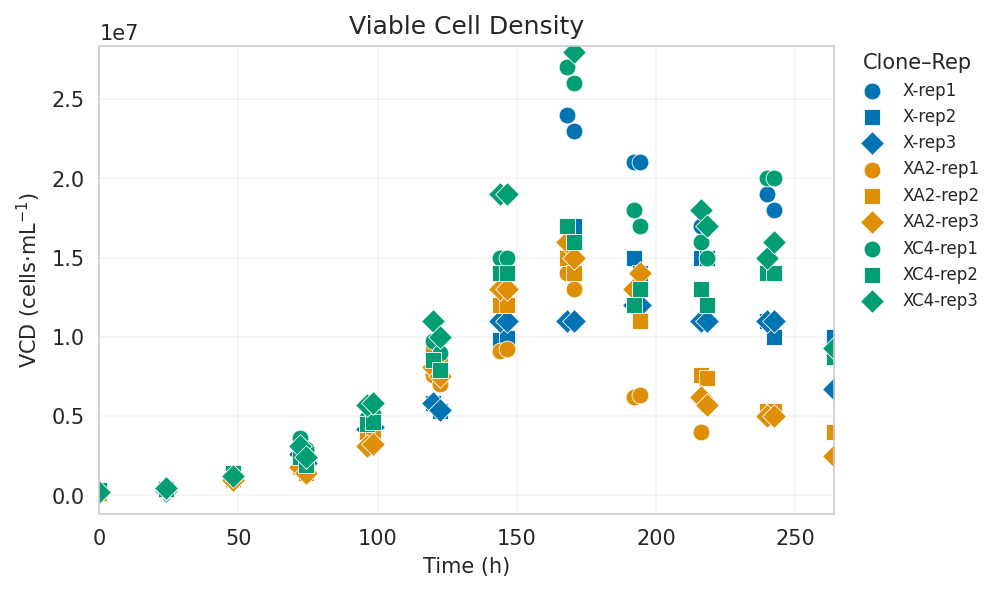

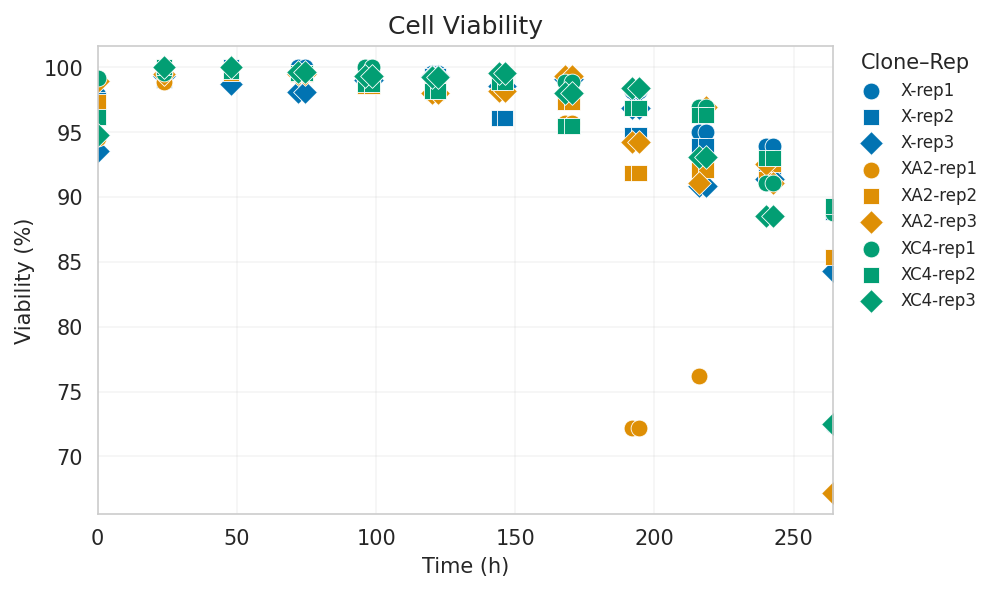

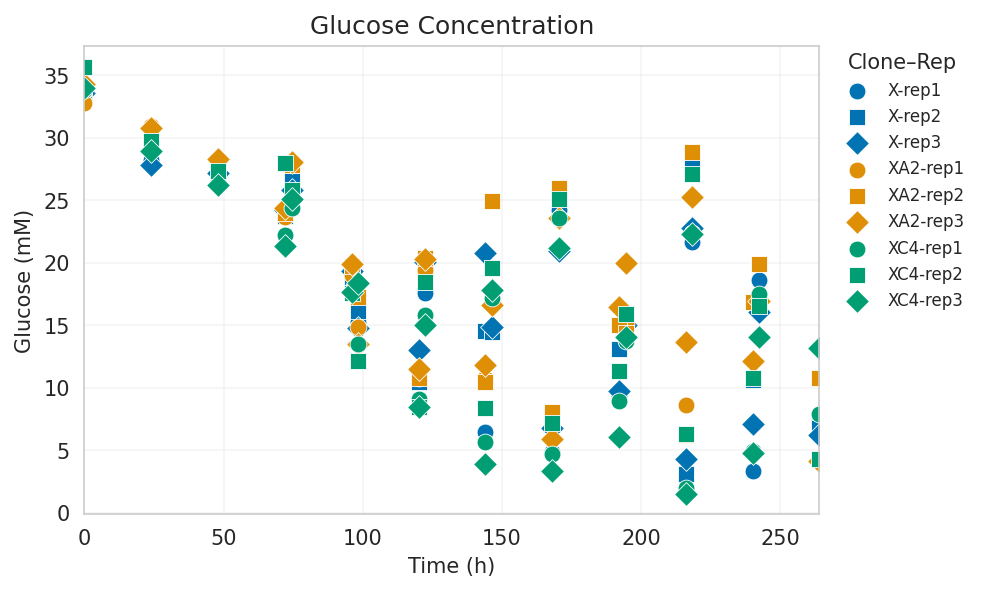

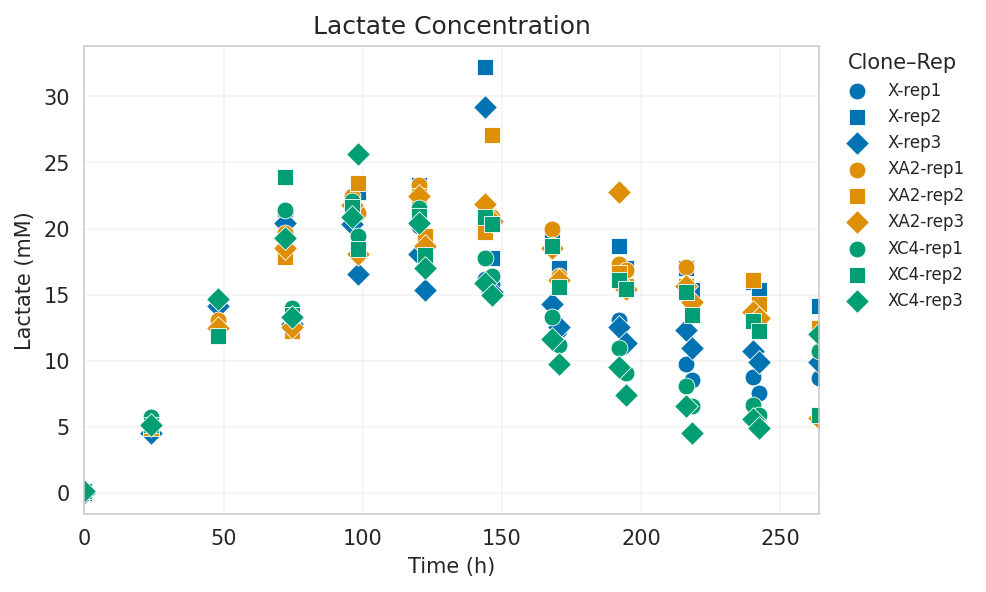

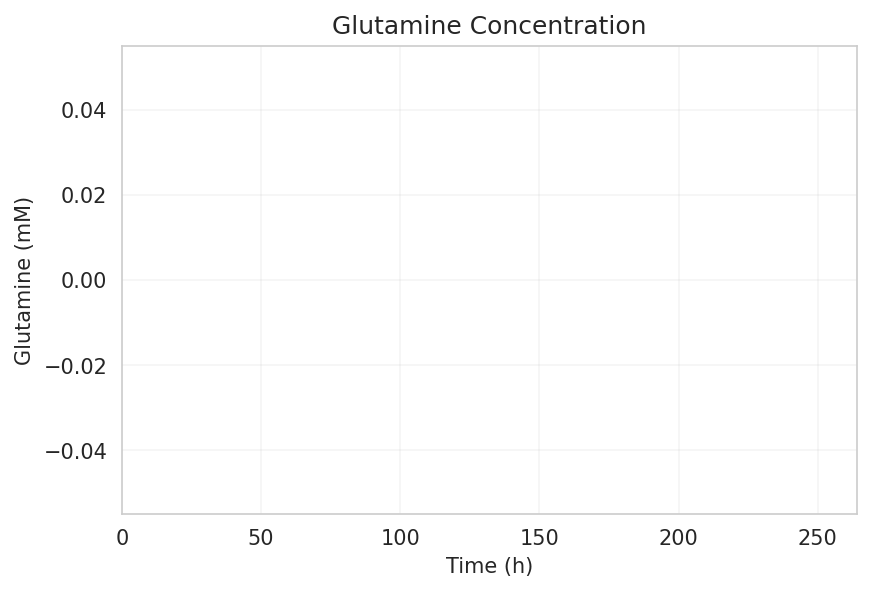

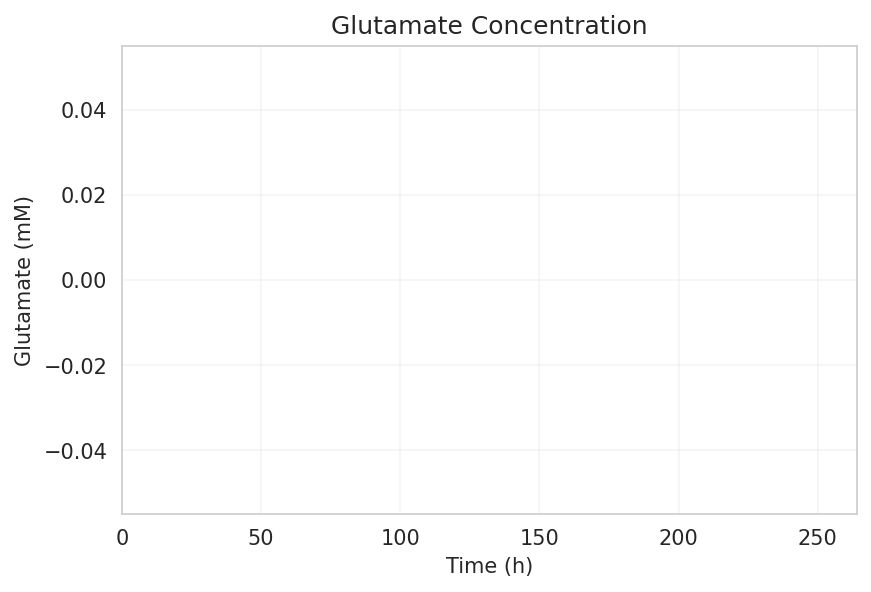

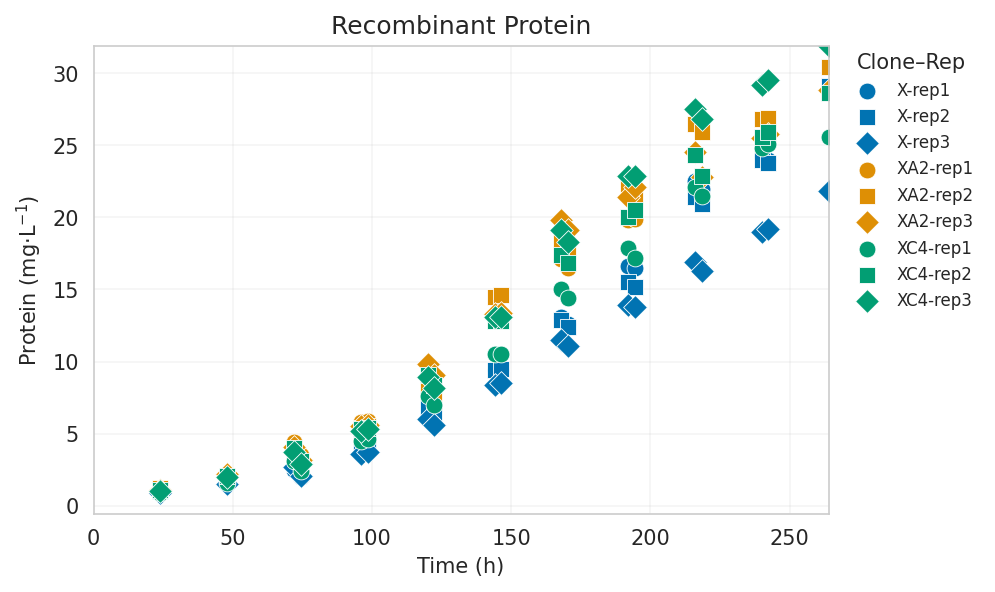

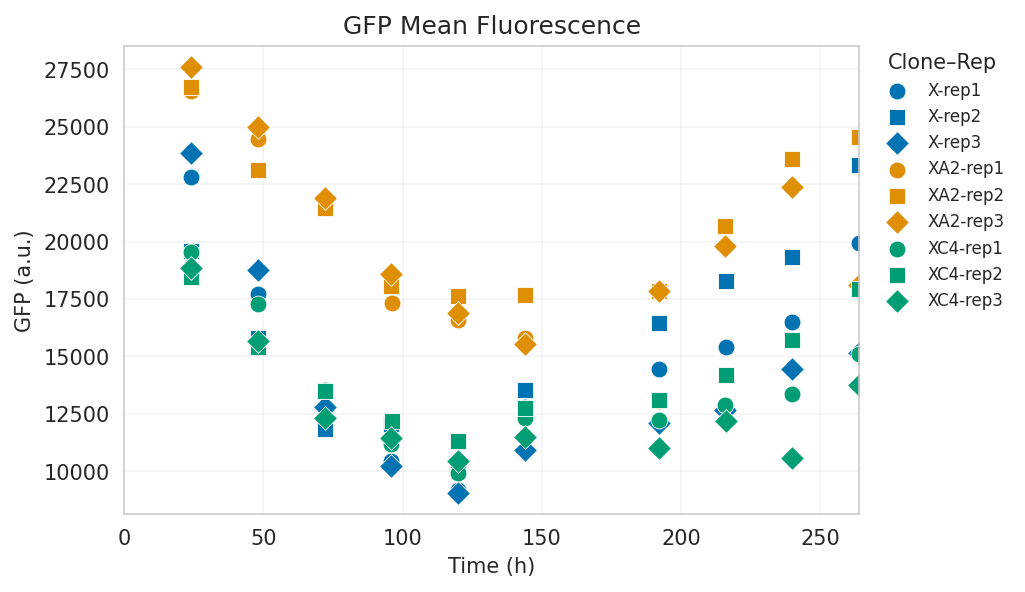

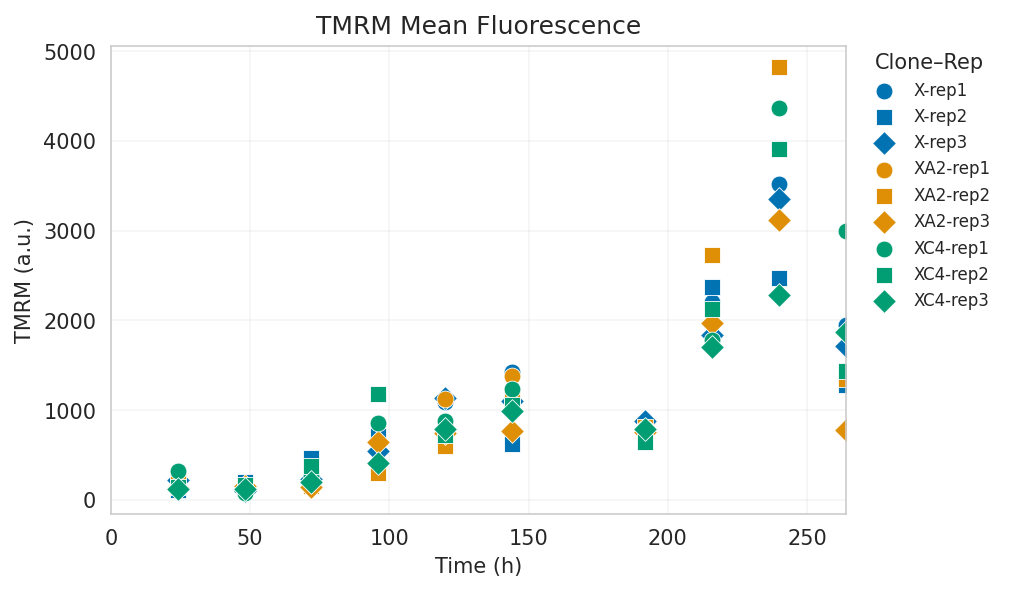

✓ Time-series: 9 figure(s) → /content/outputs/figures_raw/time


In [6]:
# =============================================================================
# Raw Time-Series Plots (uses base config + helpers)
# =============================================================================
#
# Assumes the **Plot Configuration + Environment Setup** cell has been run.
# Uses:
#   df, SUBDIRS["time"], TMAX, new_ax, scatter_by_rep, dedup_legend, save_and_maybe_show
#
# What this cell does
# -------------------
# • Lets you choose which raw variables to plot vs. time (t_hr)
# • Draws by Clone (color) and Rep (marker) using shared helpers
# • Saves PNGs to outputs/figures_raw/time/ and shows inline if SHOW_INLINE=True
# =============================================================================

from collections import OrderedDict
from pathlib import Path
import numpy as np

# -----------------------------
# 1) Plot catalog (var → (ylabel, title))
#    Edit here to add/remove variables and labels.
# -----------------------------
PLOT_TIME_CATALOG = OrderedDict([
    ("VCD",       (r"VCD (cells·mL$^{-1}$)",           "Viable Cell Density")),
    ("Viab_pct",  (r"Viability (%)",                   "Cell Viability")),
    ("Glc_mM",    (r"Glucose (mM)",                    "Glucose Concentration")),
    ("Lac_mM",    (r"Lactate (mM)",                    "Lactate Concentration")),
    ("Gln_mM",    (r"Glutamine (mM)",                  "Glutamine Concentration")),
    ("Glu_mM",    (r"Glutamate (mM)",                  "Glutamate Concentration")),
    ("rP_mg_L",   (r"Protein (mg·L$^{-1}$)",           "Recombinant Protein")),
    ("GFP_mean",  (r"GFP (a.u.)",                      "GFP Mean Fluorescence")),
    ("TMRM_mean", (r"TMRM (a.u.)",                     "TMRM Mean Fluorescence")),
])

# A small “core” subset commonly inspected first
CORE_TIME_VARS = ["VCD", "Glc_mM", "Lac_mM", "rP_mg_L"]

# -----------------------------
# 2) User selection controls (simple)
# -----------------------------
MODE = "all_present"                 # "core" | "all_present" | "custom"
CUSTOM_VARS = ["VCD"]         # used only when MODE == "custom"
LOCK_X_TO_TMAX = True         # fix X axis to [0, TMAX] if available

# -----------------------------
# 3) Resolve selection → triples (var, ylabel, title)
# -----------------------------
def pick_time_variables(mode: str, custom_vars):
    available = [v for v in PLOT_TIME_CATALOG.keys() if v in df.columns]

    if mode == "core":
        selected = [v for v in CORE_TIME_VARS if v in available]
    elif mode == "all_present":
        selected = available
    else:  # "custom"
        wanted = [str(v) for v in (custom_vars or [])]
        # keep catalog order; include only those present & requested
        selected = [v for v in PLOT_TIME_CATALOG.keys() if (v in available and v in wanted)]

    triples = [(v, PLOT_TIME_CATALOG[v][0], PLOT_TIME_CATALOG[v][1]) for v in selected]
    missing = []
    if mode == "custom":
        missing = [v for v in (custom_vars or []) if v not in available]
    return triples, available, missing

PLOT_TIME, _available, _missing = pick_time_variables(MODE, CUSTOM_VARS)

# Feedback
print("✓ Time-series selection")
print("  • Mode       :", MODE)
print("  • Available  :", _available)
if MODE == "custom":
    print("  • Requested  :", CUSTOM_VARS)
    if _missing:
        print("  • Missing    :", _missing)

if not PLOT_TIME:
    raise ValueError(
        "No valid time-series variables selected. "
        "Switch MODE or update CUSTOM_VARS to continue."
    )

# Ensure output dir exists
OUT_TIME = Path(SUBDIRS["time"])
OUT_TIME.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 4) Plot loop (consistent canvas & legend)
# -----------------------------
saved = 0
for var, ylab, title in PLOT_TIME:
    # build figure/axes with shared layout
    fig, ax = new_ax(title=title, xlabel="Time (h)", ylabel=ylab)

    # optional fixed X range
    if LOCK_X_TO_TMAX and (TMAX is not None) and np.isfinite(TMAX):
        ax.set_xlim(0, TMAX)

    # draw points by Clone/Rep
    scatter_by_rep(ax, df, x="t_hr", y=var)

    # auto Y-range, keep X as set
    ax.relim(); ax.autoscale_view(scalex=False, scaley=True)

    # legend: one entry per Clone–Rep
    dedup_legend(ax, title="Clone–Rep", fontsize=8)

    # save & maybe show
    outpath = OUT_TIME / f"{var}_raw.png"
    save_and_maybe_show(fig, outpath)
    saved += 1

print(f"✓ Time-series: {saved} figure(s) → {OUT_TIME.resolve()}")


### ⚗️ Kinetics Plots (uses base config + helpers)

Builds **time-based kinetic figures** (growth, exposure, balances, rates, yields) and saves them under `outputs/figures_raw/kinetics/`.

**What it does**
- Plots selected kinetic metrics vs. `t_hr` using a curated catalog (var → ylabel, title, category).
- Uses shared helpers for consistent axes, legend, and saving.

**User controls**
- `MODE`: `"core"` | `"all_present"` | `"rates_only"` | `"balances_only"` | `"yields_only"` | `"custom"`
- `CUSTOM_VARS`: list of column names when `MODE="custom"`
- `LOCK_X_TO_TMAX`: fix x-axis to `[0, TMAX]`
- `CLAMP_RATES_TO_POSITIVE`: set `y ≥ 0` for variables in `RATE_SET`

**Visuals**
- Constant drawing area via `AXES_RECT`; deduplicated legend (outside if `LEGEND_OUTSIDE=True`).
- Colors by `COLOR` (per *Clone*), markers by `SHAPE_MAP` (per *Rep*).

**Output**
- One PNG per variable (`*_raw.png`) at `SAVE_DPI`, also shown inline when `SHOW_INLINE=True`.


✓ Kinetics selection
  • Mode       : all_present
  • Available  : ['mu', 'IVCD_tot', 'dX', 'dG', 'dL', 'dQln', 'dQlu', 'dP', 'q_G', 'q_L', 'q_Gln', 'q_Glu', 'q_rP', 'Y_XG', 'Y_XL', 'Y_XQln', 'Y_XQlu']


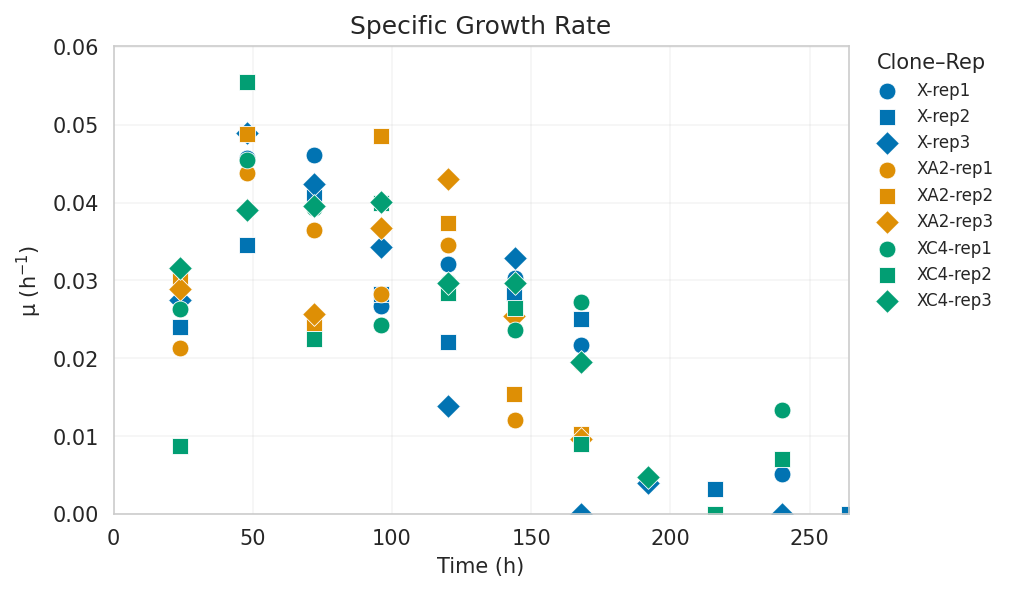

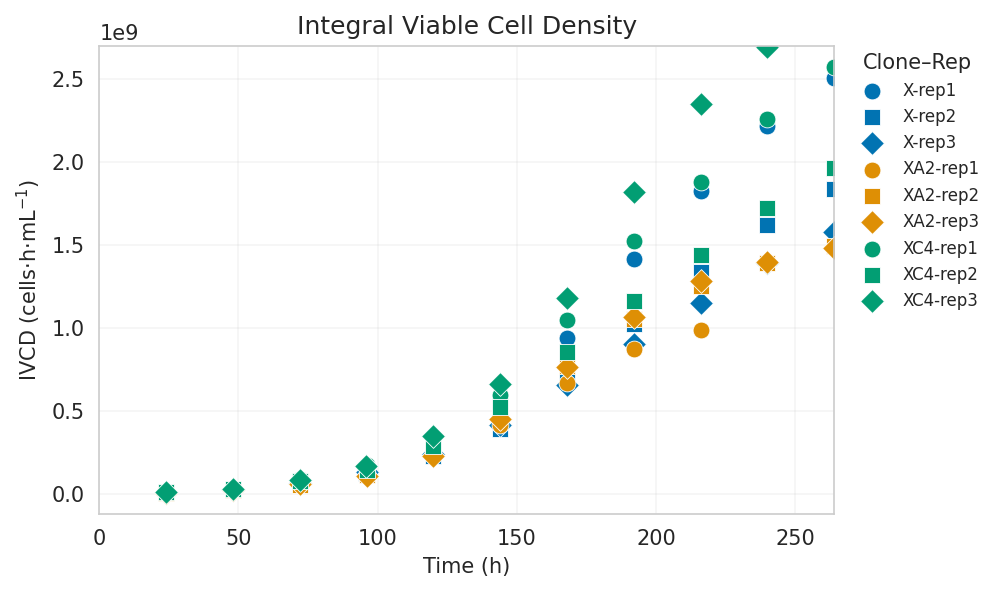

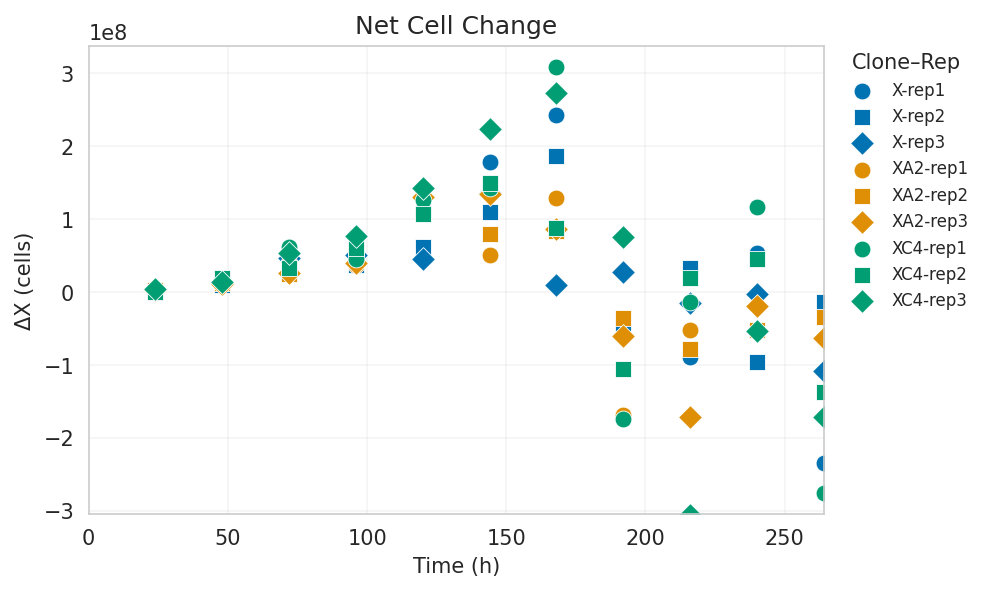

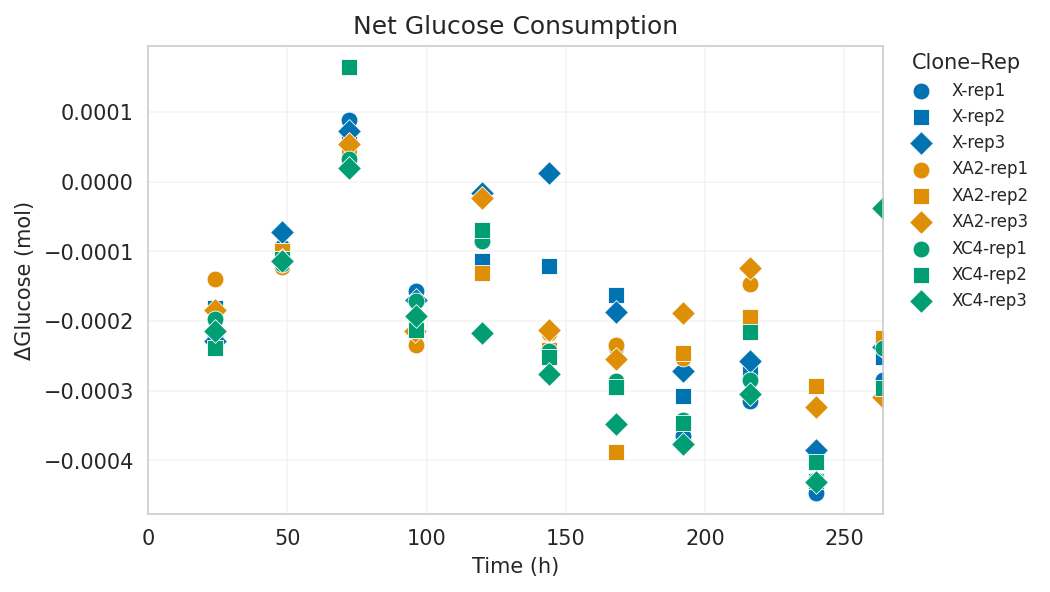

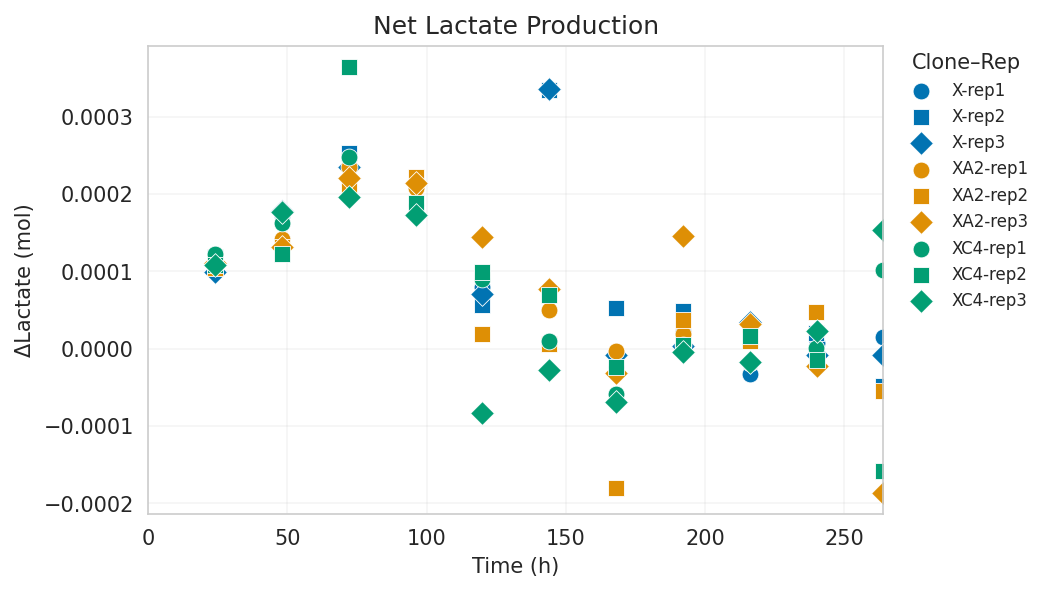

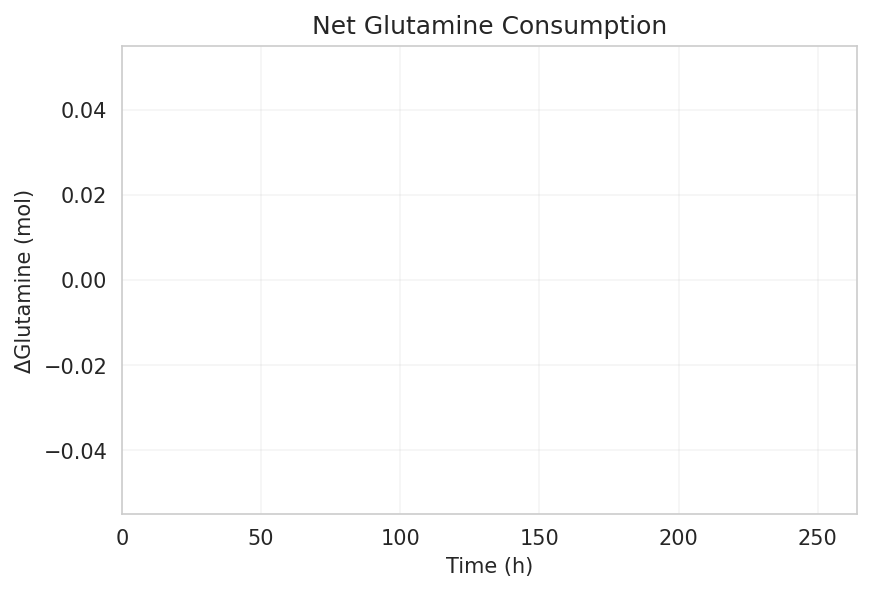

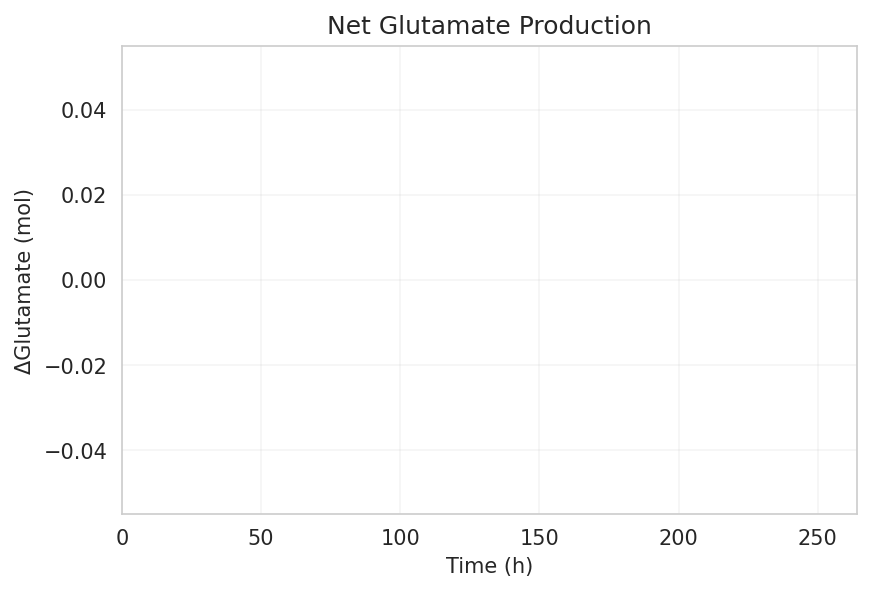

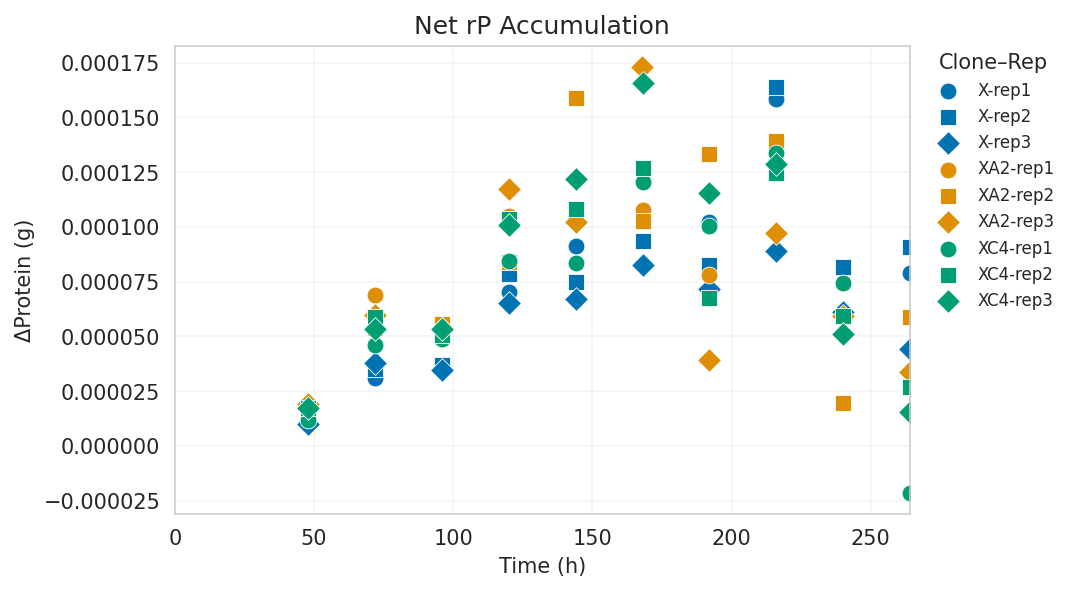

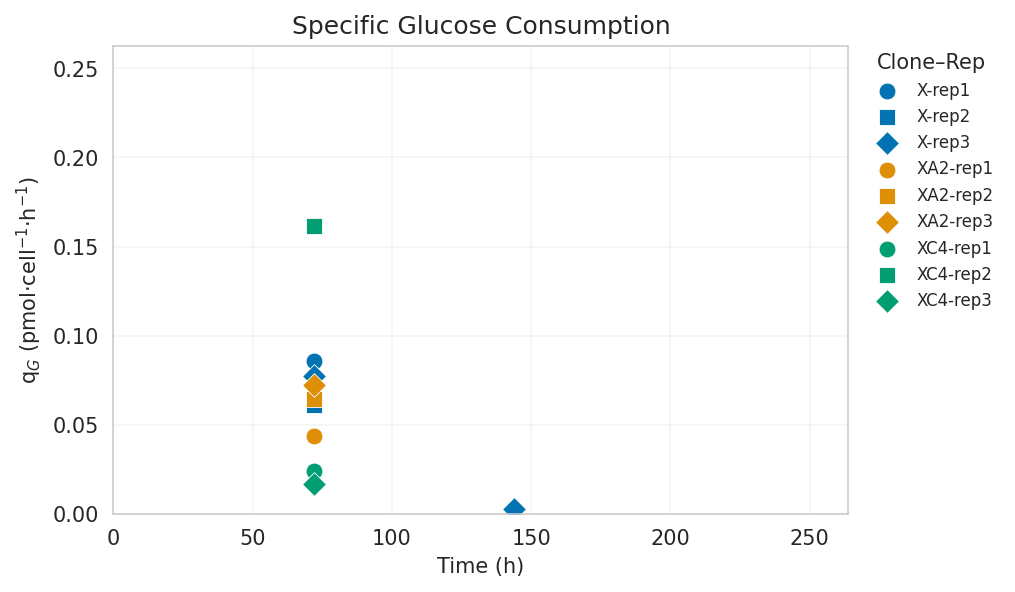

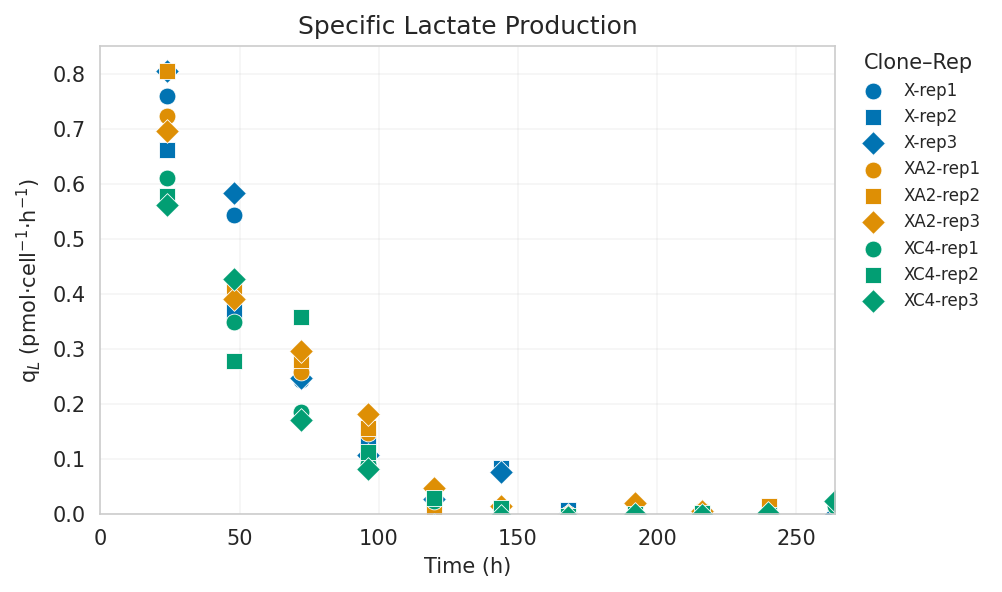

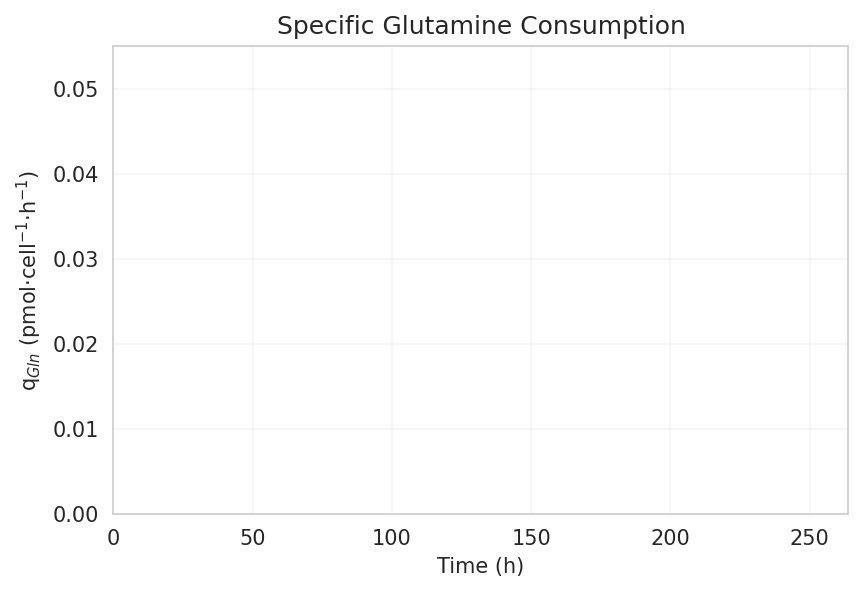

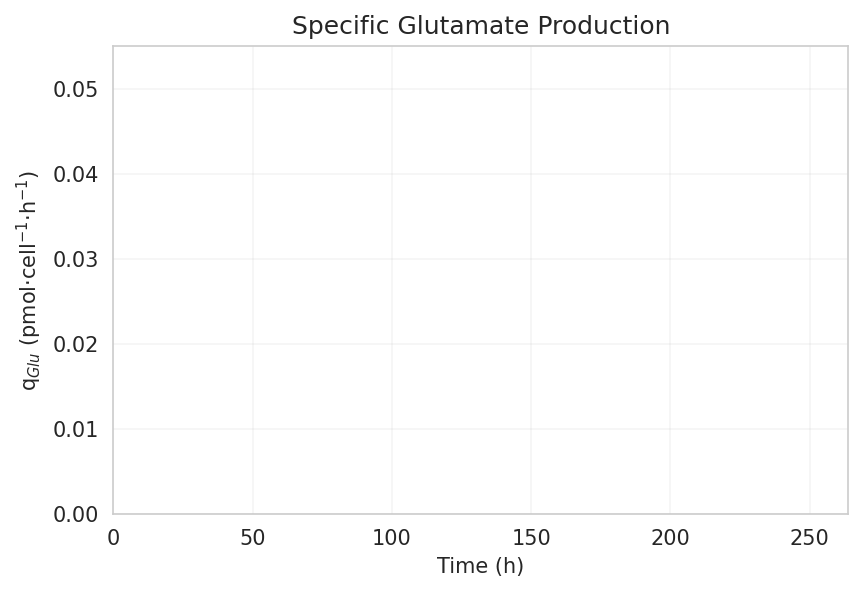

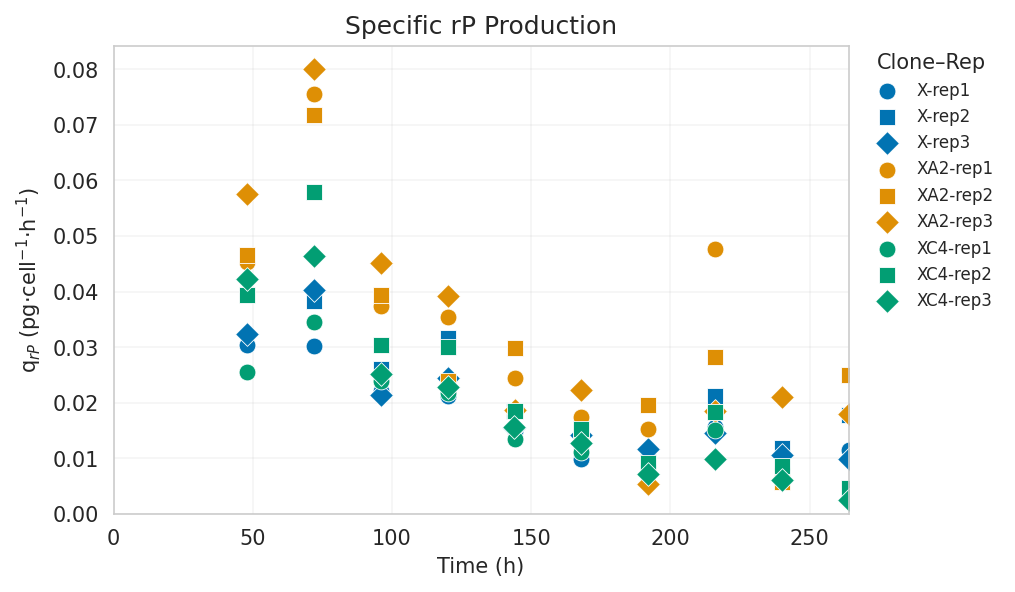

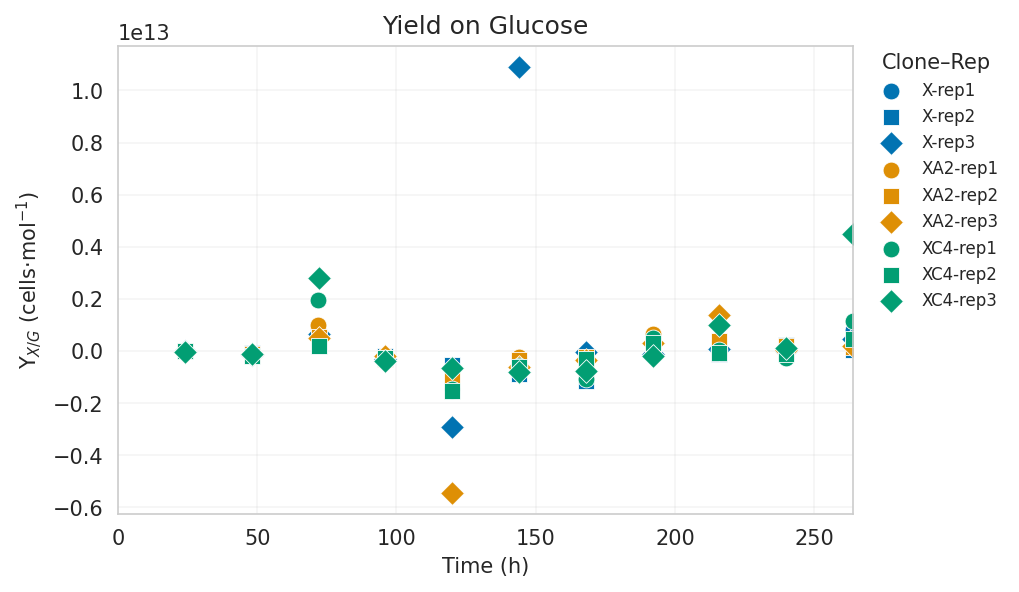

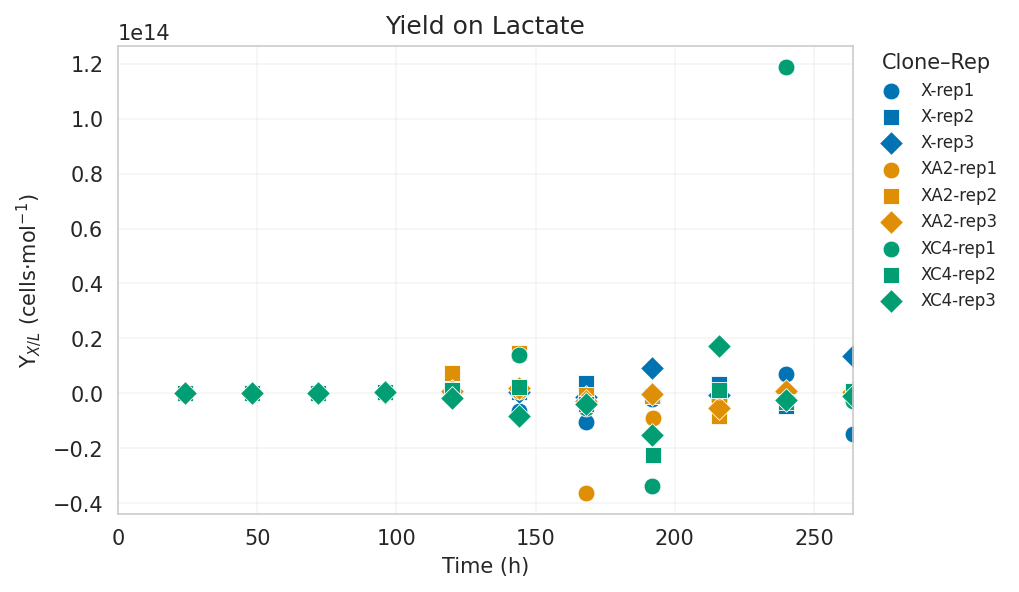

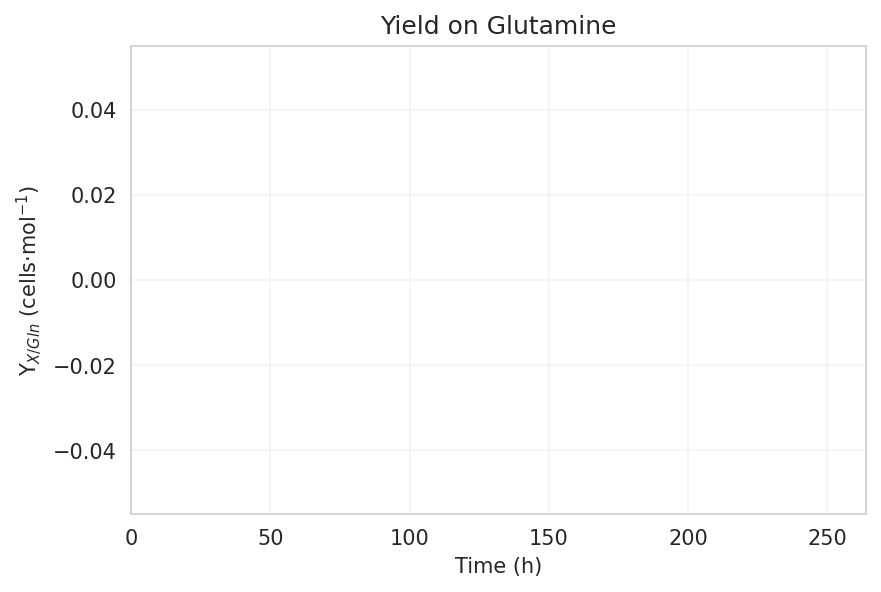

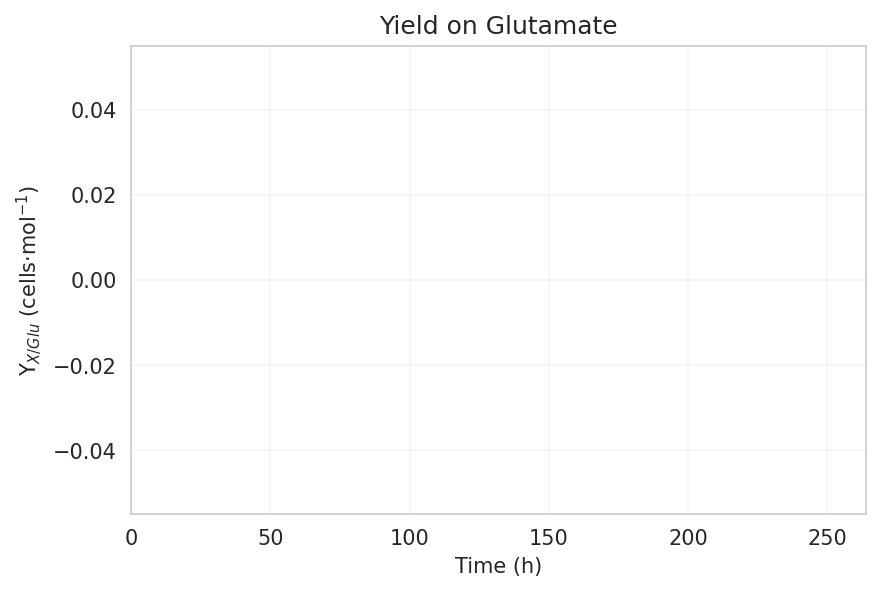

✓ Kinetics: 17 figure(s) → /content/outputs/figures_raw/kinetics


In [10]:
# =============================================================================
# Kinetics Plots (uses base config + helpers)
# =============================================================================
#
# Assumes the **Plot Configuration + Environment Setup** cell has been run.
# Uses:
#   df, SUBDIRS["kinetics"], TMAX, RATE_SET,
#   new_ax, scatter_by_rep, dedup_legend, save_and_maybe_show
#
# What this cell does
# -------------------
# • Lets you choose which kinetic metrics to plot vs. time (t_hr)
# • Categories: growth, exposure, balances, rates, yields
# • Saves PNGs to outputs/figures_raw/kinetics/ and shows inline if SHOW_INLINE=True
# =============================================================================

from collections import OrderedDict
from pathlib import Path
import numpy as np

# -----------------------------
# 1) Plot catalog (var → (ylabel, title, category))
#    Categories: "growth" | "exposure" | "balance" | "rate" | "yield"
# -----------------------------
PLOT_KIN_CATALOG = OrderedDict([
    ("mu",       (r"μ (h$^{-1}$)",                          "Specific Growth Rate",               "growth")),
    ("IVCD_tot", (r"IVCD (cells·h·mL$^{-1}$)",              "Integral Viable Cell Density",       "exposure")),

    ("dX",       (r"ΔX (cells)",                            "Net Cell Change",                    "balance")),
    ("dG",       (r"ΔGlucose (mol)",                        "Net Glucose Consumption",            "balance")),
    ("dL",       (r"ΔLactate (mol)",                        "Net Lactate Production",             "balance")),
    ("dQln",     (r"ΔGlutamine (mol)",                      "Net Glutamine Consumption",          "balance")),
    ("dQlu",     (r"ΔGlutamate (mol)",                      "Net Glutamate Production",           "balance")),
    ("dP",       (r"ΔProtein (g)",                          "Net rP Accumulation",                "balance")),

    ("q_G",      (r"q$_G$ (pmol·cell$^{-1}$·h$^{-1}$)",     "Specific Glucose Consumption",       "rate")),
    ("q_L",      (r"q$_L$ (pmol·cell$^{-1}$·h$^{-1}$)",     "Specific Lactate Production",        "rate")),
    ("q_Gln",    (r"q$_{Gln}$ (pmol·cell$^{-1}$·h$^{-1}$)", "Specific Glutamine Consumption",     "rate")),
    ("q_Glu",    (r"q$_{Glu}$ (pmol·cell$^{-1}$·h$^{-1}$)", "Specific Glutamate Production",      "rate")),
    ("q_rP",     (r"q$_{rP}$ (pg·cell$^{-1}$·h$^{-1}$)",    "Specific rP Production",             "rate")),

    ("Y_XG",     (r"Y$_{X/G}$ (cells·mol$^{-1}$)",          "Yield on Glucose",                   "yield")),
    ("Y_XL",     (r"Y$_{X/L}$ (cells·mol$^{-1}$)",          "Yield on Lactate",                   "yield")),
    ("Y_XQln",   (r"Y$_{X/Gln}$ (cells·mol$^{-1}$)",        "Yield on Glutamine",                 "yield")),
    ("Y_XQlu",   (r"Y$_{X/Glu}$ (cells·mol$^{-1}$)",        "Yield on Glutamate",                 "yield")),
])

# A small “core” subset often inspected first
CORE_KIN_VARS = ["mu", "IVCD_tot", "q_G", "q_L", "q_rP"]

# -----------------------------
# 2) User selection controls (simple)
# -----------------------------
MODE = "all_present"                 # "core" | "all_present" | "rates_only" | "balances_only" | "yields_only" | "custom"
CUSTOM_VARS = ["mu", "q_rP"]  # used only when MODE == "custom"
LOCK_X_TO_TMAX = True         # fix X axis to [0, TMAX] if available
CLAMP_RATES_TO_POSITIVE = True  # set Y ≥ 0 for variables in RATE_SET

# -----------------------------
# 3) Resolve selection → triples (var, ylabel, title)
# -----------------------------
def pick_kin_variables(mode: str, custom_vars):
    available = [v for v in PLOT_KIN_CATALOG.keys() if v in df.columns]

    # Build category mapping
    by_cat = {}
    for v, (_, _, cat) in PLOT_KIN_CATALOG.items():
        by_cat.setdefault(cat, []).append(v)

    if mode == "core":
        selected = [v for v in CORE_KIN_VARS if v in available]
    elif mode == "all_present":
        selected = available
    elif mode == "rates_only":
        selected = [v for v in by_cat.get("rate", []) if v in available]
    elif mode == "balances_only":
        selected = [v for v in by_cat.get("balance", []) if v in available]
    elif mode == "yields_only":
        selected = [v for v in by_cat.get("yield", []) if v in available]
    else:  # "custom"
        wanted = [str(v) for v in (custom_vars or [])]
        selected = [v for v in PLOT_KIN_CATALOG.keys() if (v in available and v in wanted)]

    triples = [(v, PLOT_KIN_CATALOG[v][0], PLOT_KIN_CATALOG[v][1]) for v in selected]
    missing = []
    if mode == "custom":
        missing = [v for v in (custom_vars or []) if v not in available]
    return triples, available, missing

PLOT_KIN, _available_k, _missing_k = pick_kin_variables(MODE, CUSTOM_VARS)

# Feedback
print("✓ Kinetics selection")
print("  • Mode       :", MODE)
print("  • Available  :", _available_k)
if MODE == "custom":
    print("  • Requested  :", CUSTOM_VARS)
    if _missing_k:
        print("  • Missing    :", _missing_k)

if not PLOT_KIN:
    raise ValueError(
        "No valid kinetic variables selected. "
        "Switch MODE or update CUSTOM_VARS to continue."
    )

# Ensure output dir exists
OUT_KIN = Path(SUBDIRS["kinetics"])
OUT_KIN.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 4) Plot loop (consistent canvas & legend)
# -----------------------------
saved = 0
for var, ylab, title in PLOT_KIN:
    # Build figure/axes with shared layout
    fig, ax = new_ax(title=title, xlabel="Time (h)", ylabel=ylab)

    # Optional fixed X range
    if LOCK_X_TO_TMAX and (TMAX is not None) and np.isfinite(TMAX):
        ax.set_xlim(0, TMAX)

    # Draw points by Clone/Rep
    scatter_by_rep(ax, df, x="t_hr", y=var)

    # Auto-scale Y, keep X as set
    ax.relim(); ax.autoscale_view(scalex=False, scaley=True)

    # Optional clamp for rates (≥ 0)
    if CLAMP_RATES_TO_POSITIVE and (var in RATE_SET):
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(bottom=max(0, ymin))

    # Legend: one entry per Clone–Rep
    dedup_legend(ax, title="Clone–Rep", fontsize=8)

    # Save & maybe show
    outpath = OUT_KIN / f"{var}_raw.png"
    save_and_maybe_show(fig, outpath)
    saved += 1

print(f"✓ Kinetics: {saved} figure(s) → {OUT_KIN.resolve()}")


### 🔗 Correlation Plots (uses base config + helpers)

Generates **pairwise scatter plots** (color by *Clone*, marker by *Rep*) and saves them under `outputs/figures_raw/corr/`.

**What it does**
- Uses a simple catalog of variable pairs and axis labels.
- Builds one figure per pair; skips pairs not present in `df`.

**User controls**
- Edit `PAIR_CORR` to add/remove `(x, y)` pairs.
- Optional clamping for rate variables: axes set to `≥ 0` when a variable is in `RATE_SET`.

**Visuals**
- Constant drawing area via `AXES_RECT`; deduplicated legend (outside if `LEGEND_OUTSIDE=True`).
- Colors by `COLOR` (per *Clone*), markers by `SHAPE_MAP` (per *Rep*).

**Output**
- One PNG per pair (`x_vs_y_raw.png`) at `SAVE_DPI`, also shown inline when `SHOW_INLINE=True`.


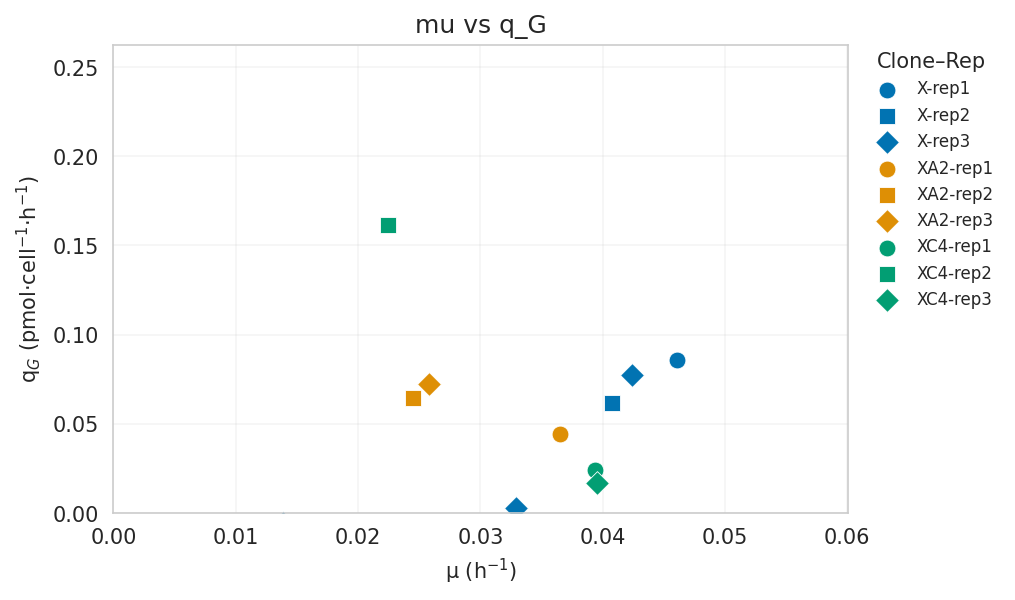

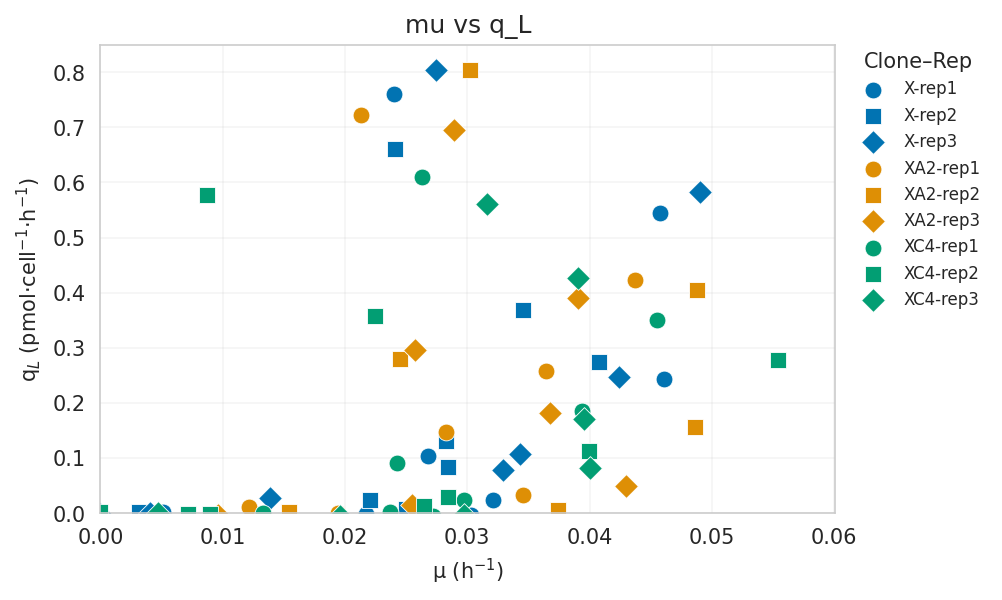

ℹ️ Skipping (no data): mu vs q_Gln
ℹ️ Skipping (no data): mu vs q_Glu


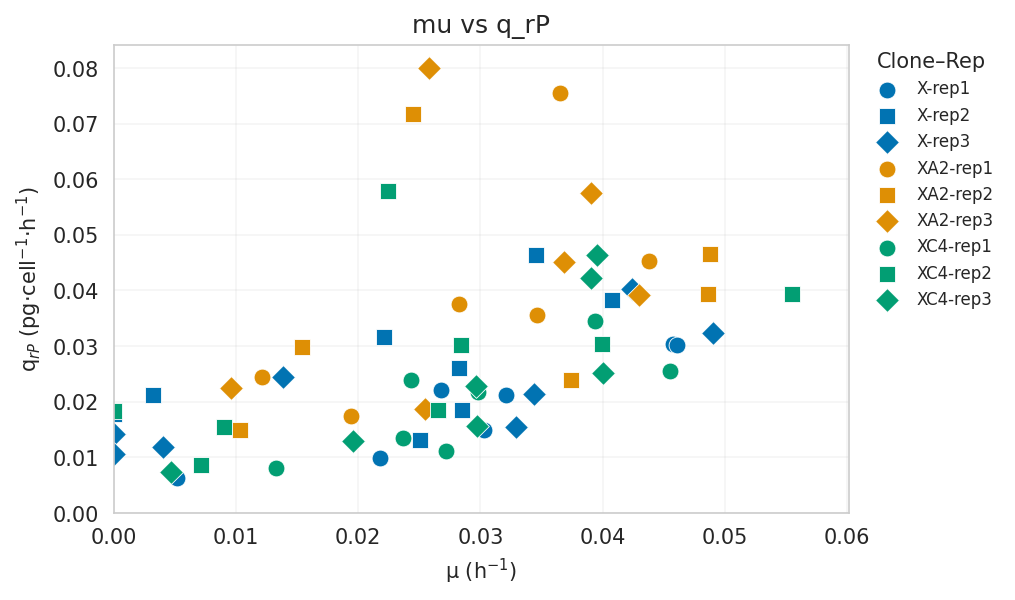

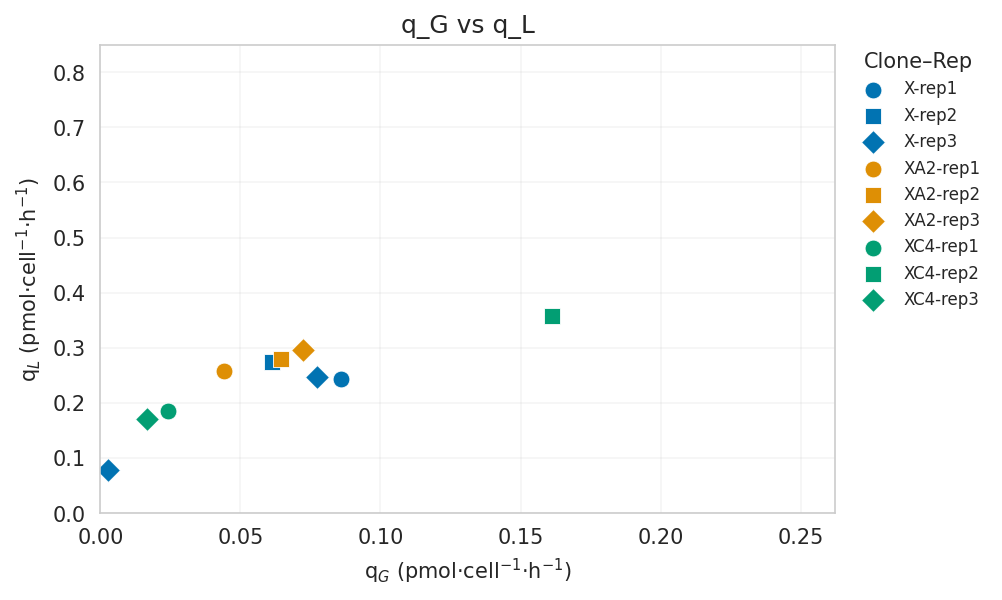

ℹ️ Skipping (no data): q_Gln vs q_Glu


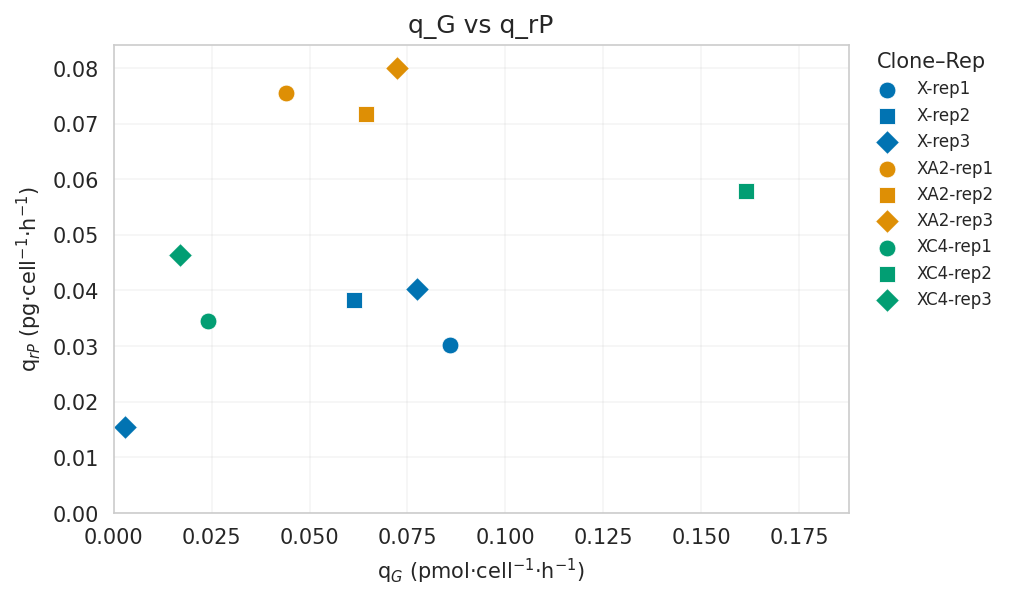

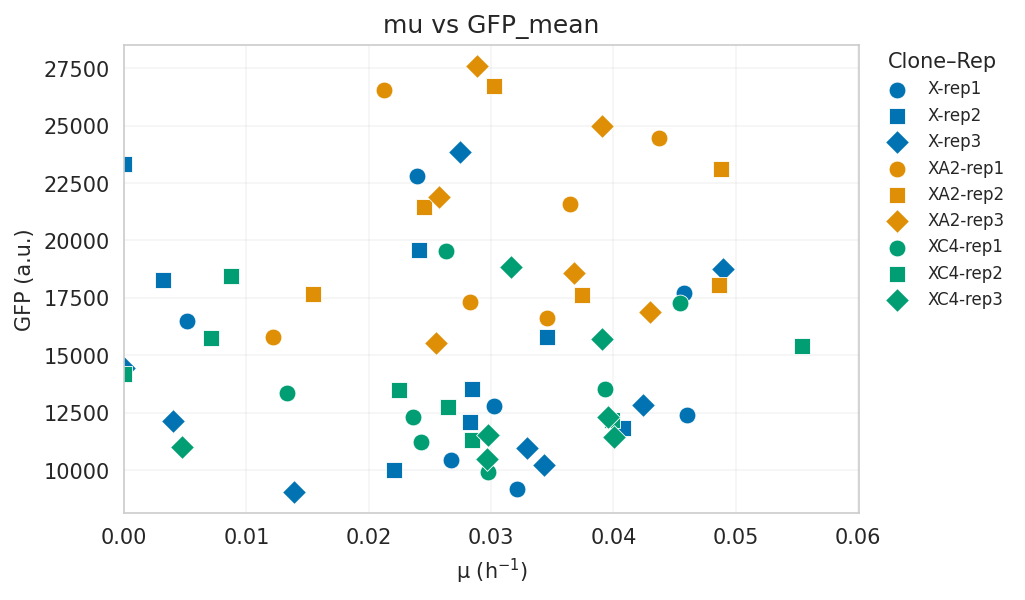

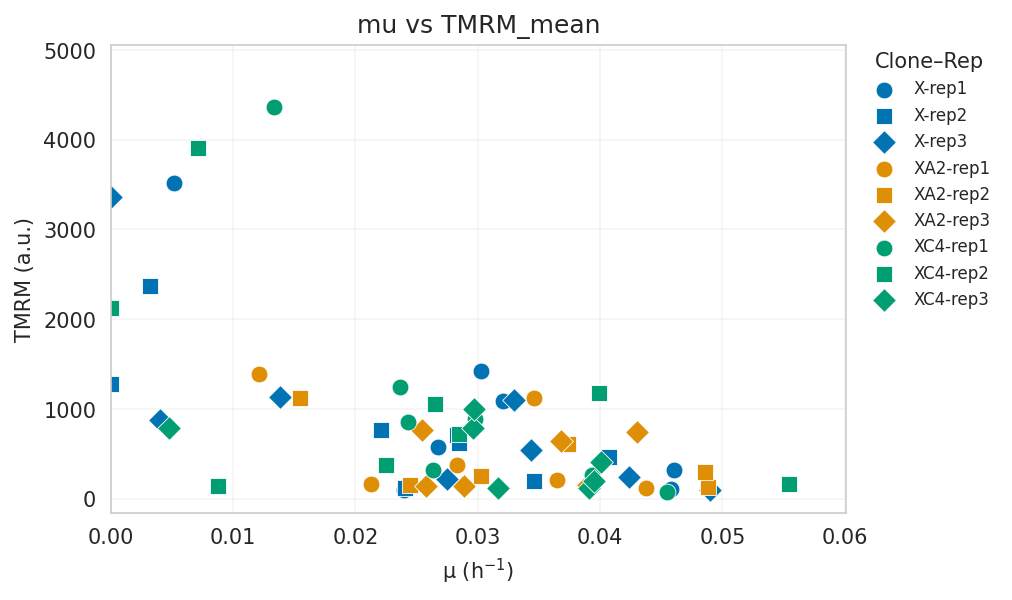

✓ Correlations: 7 figure(s) → /content/outputs/figures_raw/corr


In [8]:
# =============================================================================
# Correlation Plots (uses base config + helpers)
# =============================================================================
#
# Assumes the **Plot Configuration + Environment Setup** cell has been run.
# Uses:
#   df, SUBDIRS["corr"], RATE_SET,
#   new_ax, scatter_by_rep, dedup_legend, save_and_maybe_show
#
# What this cell does
# -------------------
# • Defines a simple catalog of correlation pairs and axis labels
# • Builds pairwise scatter plots (color by Clone, marker by Rep)
# • Saves PNGs to outputs/figures_raw/corr/ and shows inline if SHOW_INLINE=True
# =============================================================================

from pathlib import Path
import numpy as np

# -----------------------------
# 1) Axis labels
# -----------------------------
CORR_LABELS = {
    "mu":        r'μ (h$^{-1}$)',
    "q_G":       r'q$_G$ (pmol·cell$^{-1}$·h$^{-1}$)',
    "q_L":       r'q$_L$ (pmol·cell$^{-1}$·h$^{-1}$)',
    "q_Gln":     r'q$_{Gln}$ (pmol·cell$^{-1}$·h$^{-1}$)',
    "q_Glu":     r'q$_{Glu}$ (pmol·cell$^{-1}$·h$^{-1}$)',
    "q_rP":      r'q$_{rP}$ (pg·cell$^{-1}$·h$^{-1}$)',
    "GFP_mean":  r'GFP (a.u.)',
    "TMRM_mean": r'TMRM (a.u.)',
}

# -----------------------------
# 2) Pairs to plot (edit this list if needed)
# -----------------------------
PAIR_CORR = [
    ("mu","q_G"), ("mu","q_L"), ("mu","q_Gln"),
    ("mu","q_Glu"), ("mu","q_rP"),
    ("q_G","q_L"), ("q_Gln","q_Glu"), ("q_G","q_rP"),
    ("mu","GFP_mean"), ("mu","TMRM_mean"),
]

# Output folder
OUT_CORR = Path(SUBDIRS["corr"])
OUT_CORR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 3) Plot loop
# -----------------------------
saved = 0
for x, y in PAIR_CORR:
    # Skip if any variable is missing
    if {x, y}.difference(df.columns):
        print(f"ℹ️ Skipping (missing): {x}, {y}")
        continue

    # Drop rows with NaNs in either variable
    sub = df.dropna(subset=[x, y])
    if sub.empty:
        print(f"ℹ️ Skipping (no data): {x} vs {y}")
        continue

    # Build figure
    title = f"{x} vs {y}"
    fig, ax = new_ax(title=title,
                     xlabel=CORR_LABELS.get(x, x),
                     ylabel=CORR_LABELS.get(y, y))

    # Draw points by Clone/Rep (no X jitter for correlations)
    scatter_by_rep(ax, sub, x=x, y=y, jitter_if_integer_x=False)

    # Auto-scale both axes
    ax.relim(); ax.autoscale_view()

    # Optional: clamp axes for rate variables to positive domain
    if x in RATE_SET:
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(left=max(0, xmin))
    if y in RATE_SET:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(bottom=max(0, ymin))

    # Legend
    dedup_legend(ax, title="Clone–Rep", fontsize=8)

    # Save & maybe show
    outpath = OUT_CORR / f"{x}_vs_{y}_raw.png"
    save_and_maybe_show(fig, outpath)
    saved += 1

print(f"✓ Correlations: {saved} figure(s) → {OUT_CORR.resolve()}")


### 📦 Zip the outputs/ folder + optional download

Bundles **everything under `outputs/`** into a ZIP archive and (optionally) triggers a download if running in Colab.

**What it does**
- Creates `Clonalyzer_outputs[_YYYYMMDD-HHMMSS].zip` at the project root.
- Keeps the internal folder structure (`outputs/...`).
- Prints the absolute path and size; shows a clickable link outside Colab.

**User controls**
- `CREATE_ZIP` — enable/disable zip creation  
- `DOWNLOAD_AFTER_SAVE` — try to auto-download in Colab  
- `ZIP_BASENAME` — base filename (no `.zip`)  
- `TIMESTAMP_IN_NAME` — append a timestamp to avoid overwriting

**Output**
- A single ZIP file containing all generated CSVs and figures in `outputs/`.


In [9]:
# =============================================================================
# Zip the outputs/ folder + optional download
# =============================================================================
#
# Creates a ZIP archive containing EVERYTHING under `outputs/`.
# The user decides whether to create the ZIP and whether to trigger a download (Colab).
#
# Controls (Colab-style @param; in other environments they are plain variables):
#   CREATE_ZIP           : if False, do nothing (just print a tip)
#   DOWNLOAD_AFTER_SAVE  : if True and running in Colab, try to download the ZIP
#   ZIP_BASENAME         : base filename for the ZIP (without .zip)
#   TIMESTAMP_IN_NAME    : append a timestamp to avoid overwriting
# =============================================================================

from pathlib import Path
from datetime import datetime
import shutil

# --- User controls ---
CREATE_ZIP = True            #@param {type:"boolean"}
DOWNLOAD_AFTER_SAVE = True   #@param {type:"boolean"}
ZIP_BASENAME = "Clonalyzer_outputs"  #@param {type:"string"}
TIMESTAMP_IN_NAME = True     #@param {type:"boolean"}

# --- Paths ---
PROJECT_ROOT = Path.cwd()
OUTPUTS_DIR  = PROJECT_ROOT / "outputs"

if not CREATE_ZIP:
    print("ℹ️ CREATE_ZIP=False — enable it to generate the ZIP archive.")
    print(f"   Expected folder to compress: {OUTPUTS_DIR.resolve()}")
else:
    if not OUTPUTS_DIR.exists():
        raise FileNotFoundError(
            f"outputs/ folder not found at: {OUTPUTS_DIR.resolve()}\n"
            "Run previous blocks to generate results before zipping."
        )

    # ZIP filename
    ts = datetime.now().strftime("%Y%m%d-%H%M%S") if TIMESTAMP_IN_NAME else ""
    base = f"{ZIP_BASENAME}_{ts}" if ts else ZIP_BASENAME
    zip_path = PROJECT_ROOT / f"{base}.zip"

    # Create the ZIP: internal structure keeps top-level 'outputs/' folder
    archive = shutil.make_archive(
        base_name=str(zip_path.with_suffix("")),
        format="zip",
        root_dir=str(PROJECT_ROOT),
        base_dir=str(OUTPUTS_DIR.name)
    )
    zip_path = Path(archive)

    size_mb = zip_path.stat().st_size / (1024 * 1024)
    print(f"✅ ZIP created → {zip_path.resolve()}  ({size_mb:.2f} MB)")

    # Try to trigger a download in Colab; otherwise show a clickable link
    downloaded = False
    if DOWNLOAD_AFTER_SAVE:
        try:
            from google.colab import files  # type: ignore
            print("⬇️ Triggering download…")
            files.download(str(zip_path))
            downloaded = True
        except Exception:
            print("ℹ️ Not running in Colab; cannot trigger an automatic download.")

    if not downloaded:
        try:
            from IPython.display import FileLink, display
            display(FileLink(str(zip_path), result_html_prefix="Download: "))
        except Exception:
            print(f"Download manually from: {zip_path.resolve()}")


✅ ZIP created → /content/Clonalyzer_outputs_20250819-001226.zip  (2.09 MB)
⬇️ Triggering download…


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a id="annex-calcs"></a>
<details>
<summary><b>Annex — Detailed formulas & rationale (click to expand)</b></summary>

### A. Units & conversions (why we normalize first)

Balances operate on **amount = concentration × volume**, so we convert inputs to consistent units.

- **Glucose / Lactate:** g·L$^{-1}$ → mM → mol·mL$^{-1}$

$$
\begin{aligned}
\mathrm{Glc}\,[\mathrm{mM}] &= \frac{\mathrm{Glc}\,[\mathrm{g\,L^{-1}}]}{MW_{\mathrm{Glc}}}\times 10^{3} \\
\mathrm{Lac}\,[\mathrm{mM}] &= \frac{\mathrm{Lac}\,[\mathrm{g\,L^{-1}}]}{MW_{\mathrm{Lac}}}\times 10^{3}
\end{aligned}
$$

$$
\begin{aligned}
\mathrm{Glc}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Glc}\,[\mathrm{mM}] \times 10^{-6} \\
\mathrm{Lac}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Lac}\,[\mathrm{mM}] \times 10^{-6}
\end{aligned}
$$

- **Gln / Glu:** mM → mol·mL$^{-1}$

$$
\begin{aligned}
\mathrm{Gln}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Gln}\,[\mathrm{mM}] \times 10^{-6} \\
\mathrm{Glu}\,[\mathrm{mol\,mL^{-1}}] &= \mathrm{Glu}\,[\mathrm{mM}] \times 10^{-6}
\end{aligned}
$$

- **rP:** mg·L$^{-1}$ → g·mL$^{-1}$

$$
\mathrm{rP}\,[\mathrm{g\,mL^{-1}}] \;=\; \mathrm{rP}\,[\mathrm{mg\,L^{-1}}]\times 10^{-6}
$$

<small>Constants: $MW_{\mathrm{Glc}} = 180.156$ g·mol$^{-1}$, $MW_{\mathrm{Lac}} = 90.080$ g·mol$^{-1}$.</small>

---

### B. Interval definition (why batch vs fed-batch pairing)

- **Batch:** use consecutive samples ($t_0\!\to\!t_1$).  
- **Fed-batch:** pair **last post-feed** $\to$ **next pre-feed** to avoid feed spikes contaminating balances.  
We require $\Delta t = t_1 - t_0 > 0$.

---

### C. Growth & integrals (what and why)

**C.1 Specific growth rate** (average over the interval)  
Model: $\frac{dX}{dt}=\mu X \Rightarrow X_1=X_0\,e^{\mu\,\Delta t}$. Estimator:
$$
\mu=\frac{\ln X_1-\ln X_0}{\Delta t}\quad[\mathrm{h^{-1}}].
$$
*Why:* robust, uses only endpoints, interpretable as average $\mu$ on $[t_0,t_1]$.

**C.2 IVCD (interval, per mL)**  
Definition:
$$
\mathrm{IVCD}_{\mathrm{int}}=\int_{t_0}^{t_1}X(t)\,dt\;\approx\;\frac{X_0+X_1}{2}\,\Delta t
\quad\text{(trapezoid)}.
$$
*Why trapezoid:* first-order accurate even if $X(t)$ is not exactly exponential; numerically stable when $X_1\!\approx\!X_0$. (Exact exponential integral equals $\Delta t$ times the **logarithmic mean** $L(X_0,X_1)=\frac{X_1-X_0}{\ln X_1-\ln X_0}$, which is close to the arithmetic mean for small $\mu\Delta t$.)

**C.3 IVCC (interval cell-hours, in vessel)**  
We normalize specific rates by **cell-hours in the vessel**:
$$
\int_{t_0}^{t_1}\!X(t)V(t)\,dt\;\approx\;\mathrm{IVCD}_{\mathrm{int}}\times\overline{V}
=\left(\frac{X_0+X_1}{2}\,\Delta t\right)\left(\frac{V_0+V_1}{2}\right).
$$
*Why product of averages:* first-order accurate when $X,V$ vary smoothly; naturally accounts for feed/sampling volume changes via $\overline{V}$.

**C.4 Cumulative IVCD (per mL)**  
$$
\mathrm{IVCD}_{\mathrm{tot}}(t_1)=\sum_{k:\,t_k\le t_1}\mathrm{IVCD}_{\mathrm{int}}^{(k)}.
$$
*Why:* standard “area under curve” exposure metric, scale-independent (per mL).

<small>Symbols: $X$ = VCD (cells·mL$^{-1}$), $V$ = volume (mL), $\Delta t$ in h; subscripts 0/1 mean values at $t_0$/$t_1$.</small>

---

### D. Balances & signs (concentration × volume)

- Biomass: $\Delta X = X_1V_1 - X_0V_0$ (cells)  
- Glucose (consumption $>0$): $\Delta G = S_{G,0}V_0 - S_{G,1}V_1$ (mol)  
- Lactate (production $>0$): $\Delta L = S_{L,1}V_1 - S_{L,0}V_0$ (mol)  
- Gln (consumption $>0$): $\Delta Q_{\mathrm{Gln}} = S_{\mathrm{Gln},0}V_0 - S_{\mathrm{Gln},1}V_1$ (mol)  
- Glu (production $>0$): $\Delta Q_{\mathrm{Glu}} = S_{\mathrm{Glu},1}V_1 - S_{\mathrm{Glu},0}V_0$ (mol)  
- rP (accumulation $>0$): $\Delta P = P_1V_1 - P_0V_0$ (g)

---

### E. Yields (how to read them)

Yield relates biomass change to species change:
$$
Y_{X/S}=\frac{\Delta X}{\Delta S}\quad[\mathrm{cells\;mol^{-1}}].
$$
- Substrates: $\Delta S>0\Rightarrow Y_{X/S}>0$ if biomass grew.  
- Products: $\Delta S>0$ when produced; $Y_{X/S}$ can be negative if biomass fell.  
- If $\Delta S=0\Rightarrow$ NaN (undefined). For aggregations, prefer $\bar{Y}_{X/S}=\frac{\sum\Delta X}{\sum\Delta S}$.

---

### F. Specific rates $q_\ast$ (why normalize by cell-hours)

Start from the vessel balance:
$$
\frac{d\,n_S}{dt}=q_S(t)\,X(t)\,V(t),\qquad
\Delta S=\int_{t_0}^{t_1}q_S(t)\,X(t)\,V(t)\,dt.
$$
Assuming $q_S$ $\approx$ constant on the interval:
$$
q_S\;\approx\;\frac{\Delta S}{\int_{t_0}^{t_1}X(t)V(t)\,dt}\;\approx\;\frac{\Delta S}{\mathrm{IVCC}_{\mathrm{interval}}}.
$$
Units and scaling:
- Species in mol: $\displaystyle q_S=\frac{\Delta S\times 10^{12}}{\mathrm{IVCC}_{\mathrm{interval}}}$ (pmol·cell$^{-1}$·h$^{-1}$)  
- rP in g: $\displaystyle q_{\mathrm{rP}}=\frac{\Delta P\times 10^{12}}{\mathrm{IVCC}_{\mathrm{interval}}}$ (pg·cell$^{-1}$·h$^{-1}$), using $1$ g $=10^{12}$ pg.

*Why this normalization:* makes $q_\ast$ **intensive** (per cell per hour) and comparable across volumes/clones/days; it ties directly to $\Delta S \approx q_S\int X\,V\,dt$.

---

### G. Practical notes

- Enforce $\Delta t>0$; skip ill-ordered timestamps.  
- Post-feed rows are anchors (no interval ends at them).  
- Accurate `Vol_mL` is critical; errors bias all $\Delta$ and $q$.  
- Small $\mathrm{IVCC}_{\mathrm{interval}}$ can yield large $q_\ast$ (little “cell-time” supporting a sizable $\Delta S$).

</details>
